## Imports and Function Definitions

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects

import pandas as pd
pd.set_option('display.max_columns', None)

import radvel
from kpf_etc.etc import kpf_etc_rv, kpf_photon_noise_estimate
import sys

from tess_stars2px import tess_stars2px_function_entry
import random


#Mass-Radius Relation Packages
from mrexo.mle_utils_nd import calculate_conditional_distribution

#MMW & FoM Calculation Packages from Geoff Bryden (original directory in Documents/Target Lists/redo3)
sys.path.insert(0, '/Users/jenburt/Dropbox/Projects/RepresentativePlanets/TargetListCreation/')
from thermo import *
from calcMMW import calcMMW
from relations import massMetalRelation

from astropy.modeling.models import BlackBody
from astropy import units as u

seed=int(354687632168465)
shabram_cut = 0.89

wav = 1.65 * u.um


fduty=0.9
logCtoOsolar = -0.26

def calc_g(Mp, Rp):
    G = 6.6743E-11   # m3 kg-1 s-2
    M = Mp * 5.972e+24 # Mp in Earths to kg
    R = Rp * 6.378e+6 # Rp in Earths to m
    g = (G * M) / (R ** 2.)
    return g

def calc_Hs(T, mmw, g):
    k = 1.38064852E-23
    m = mmw * 1.66054E-27 # convert AMU to kg
    return (k*T) / (m*g)

def calc_specmod(Hs, Rp, Rstar):
    R = Rp * 6.378e+6 # Rp in Earths to m
    Rs = Rstar * 6.957e+8 # Rstar in Suns to m
    return (2.*Hs*R)/(Rs**2.)

def calc_FoM(Mp, Rp, T, mmw, Rstar, Hmag):
    g = calc_g(Mp, Rp)
    Hs = calc_Hs(T, mmw, g)
    specmod = calc_specmod(Hs, Rp, Rstar)*(1E6)
    return specmod/(10.**(0.2*Hmag))

def planck(temp,wave):
    h = 6.626070040E-34
    c = 299792458.
    kB = 1.38064852E-23
    return (((2.*h*c*c)/wave**5.)/(np.exp((h*c)/(wave*kB*temp))-1.))

def eclipsedepth(temp,startemp,wave,RpRs):
    FpFs = planck(temp,wave) / planck(startemp,wave)
    transit_depth = RpRs**2.
    eclipse_depth = FpFs * transit_depth
    return eclipse_depth

def calc_FoMe(temp,startemp,wave,RpRs,Hmag):
    FpFs = eclipsedepth(temp,startemp,wave,RpRs)
    return FpFs/(10.**(0.2*Hmag))

def InferPlMass_FromPlRadius(
	pl_rade):
	"""
	Inputs:
		pl_rade = Planetary radius in Earth radius. Specify as numpy array
	Outputs:
		MeanPDF
	"""
 
	ConditionString = 'm|r'
	ConditionName = '2D_'+ConditionString.replace('|', '_').replace(',', '_')

	location='/Users/jenburt/Dropbox/Research/MassRadiusFits/FitResults/'	
	RunName = r"MR_AIC_degmax100_asymmetric"

	save_path = os.path.join(location, RunName)

	PlotFolder = os.path.join(save_path, ConditionName)
	
	if not os.path.exists(PlotFolder):
		print("2D Plot folder does not exist")
		os.mkdir(PlotFolder)
	
	deg_per_dim = np.loadtxt(os.path.join(save_path, 'output', 'deg_per_dim.txt'))
	DataDict = np.load(os.path.join(save_path, 'input', 'DataDict.npy'), allow_pickle=True).item()
	JointDist = np.load(os.path.join(save_path, 'output', 'JointDist.npy'), allow_pickle=True).T
	weights = np.loadtxt(os.path.join(save_path, 'output', 'weights.txt'))
	deg_per_dim = np.loadtxt(os.path.join(save_path, 'output', 'deg_per_dim.txt')).astype(int)
	
	Condition = ConditionString.split('|')
	LHSTerms = Condition[0].split(',')
	RHSTerms = Condition[1].split(',')
	deg_vec_per_dim = [np.arange(1, deg+1) for deg in deg_per_dim] 
	
	LHSDimensions = np.array([(np.arange(DataDict['ndim'])[np.isin(DataDict['ndim_char'] , l)])[0] for l in LHSTerms])
	RHSDimensions = np.array([(np.arange(DataDict['ndim'])[np.isin(DataDict['ndim_char'] , r)])[0] for r in RHSTerms])
	

	xdata = DataDict['ndim_data'][RHSDimensions[0]]

	Bounds = DataDict['ndim_bounds']
	
	x = np.log10(CleanInput(pl_rade))

	if not np.all(x > Bounds[0][0]) & np.all(x < Bounds[0][1]): print("Input pl_rade is out of bounds = ", *10**Bounds[0]); return np.nan

	MeasurementDict=	{
				'r':[x, [[np.nan, np.nan]]*len(x)]
	}

	ConditionalDist, MeanPDF, VariancePDF = calculate_conditional_distribution(
		ConditionString, DataDict, weights, deg_per_dim,
		JointDist.T, MeasurementDict)

	return 10**MeanPDF


def CleanInput(a):
	if type(a) == list: return np.array(a)
	elif type(a) is not np.ndarray: return np.array([a])
	else: return a
     
#KnownPlanets_Data=pd.read_csv('knowntargets_Jenn.csv',skipinitialspace=True)
#test=KnownPlanets_Data['Teff_p'][KnownPlanets_Data['Teff_p']>0]
#print(np.percentile(test, 99.7))
#test2 = test[~np.isnan(test)]
#print(np.percentile(test2, 99.7))

# Generate Full Target List of Viable Planets / Planet Candidates

## Assemble current TOI table, remove problematic TOIs and calculate mass requirements

In [2]:
########################
# Section for TOI List #
########################

#Start from the SG2/SG4 and TEV TOI Lists
#Keep only those SG2/4 TOIs whose dispositions suggest that they're not yet known to be false positives
TOI_Input=pd.read_csv('TOI_InputCatalog_May2025.csv')  #current version of the SG4 observation planning sheet
TOI_TEV=pd.read_csv('TEV_Catalog_May2025.csv',skiprows=2) #current version of the TOI catalog from TEV

#Remove TOIs known to be false positives based on SG4 sheet
TOI_accepted_dispositions = ('CP','CPC','CPC-','CPC?','VP','VPC','VPC-','VPC-?','VPC-+','VPC?','VPC+','VPC+?','PC','PPC')
TOI_Data = TOI_Input[TOI_Input['Disposition'].isin(TOI_accepted_dispositions)]
TOI_Data.reset_index(inplace=True, drop=True)

#Add equilibrium temp column and stellar metallicity column
TOI_Data['Teq_p'] = TOI_Data['Teff_*_TIC8']*np.sqrt(1/TOI_Data['a/R*'])*(0.25**0.25)
TOI_Data['Met_*'] = [0]*len(TOI_Data)

#Add columns for TEV parameters that need to be merged into the TOI_Data dataframe
TOI_Data['R_p_error'] = np.full(len(TOI_Data),np.nan)
TOI_Data['Epoch_p_error'] = np.full(len(TOI_Data),np.nan)
TOI_Data['Period_p_error'] = np.full(len(TOI_Data),np.nan)
TOI_Data['Duration_hours'] = np.full(len(TOI_Data),np.nan)
TOI_Data['Duration_hours_error'] = np.full(len(TOI_Data),np.nan)
TOI_Data['Depth_ppm'] = np.full(len(TOI_Data),np.nan)
TOI_Data['Depth_ppm_error'] = np.full(len(TOI_Data),np.nan)
TOI_Data['Epoch_p'] = np.full(len(TOI_Data),np.nan)
TOI_Data['Epoch_p'] = np.full(len(TOI_Data),np.nan)


for i in range(0,len(TOI_Data)):
    ind = np.where(TOI_TEV['Full TOI ID'] == TOI_Data['TOI'][i])
    if any(ind):
        TOI_Data['Epoch_p'][i] = TOI_TEV['Orbital Epoch Value'][ind[0][0]]+2457000.    #TOI_TEV.iloc[935]['Epoch Value']+2457000. 
        TOI_Data['Epoch_p_error'][i] = TOI_TEV['Epoch Uncertainty'][ind[0][0]]
        TOI_Data['Period_p'][i] = TOI_TEV['Orbital Period Value'][ind[0][0]]
        TOI_Data['Period_p_error'][i] = TOI_TEV['Orbital Period Uncertainty'][ind[0][0]]
        TOI_Data['Duration_hours'][i] = TOI_TEV['Transit Duration (hours) Value'][ind[0][0]]
        TOI_Data['Duration_hours_error'][i] = TOI_TEV['Transit Duration (hours) Uncertainty'][ind[0][0]]
        TOI_Data['Depth_ppm'][i] = TOI_TEV['Transit Depth Value'][ind[0][0]]
        TOI_Data['Depth_ppm_error'][i] = TOI_TEV['Transit Depth Uncertainty'][ind[0][0]]
        if ~np.isnan(TOI_TEV['Planet Radius Value'][ind[0][0]]):
            TOI_Data['R_p'][i] = TOI_TEV['Planet Radius Value'][ind[0][0]]
            TOI_Data['R_p_error'][i] = TOI_TEV['Planet Radius Uncertainty'][ind[0][0]]
    else:
        print('TOI not found / found multiple times in TEV list: ',TOI_Data['TOI'][i])

print('Starting number of TOIs: ',len(TOI_Data))
TOI_Data = TOI_Data[(~np.isnan(TOI_Data['Period_p_error'])) & 
                    (~np.isnan(TOI_Data['R_p'])) & (~np.isnan(TOI_Data['Epoch_p']))]
print('Number of TOIs after NaN clean up: ',len(TOI_Data))

#Start by removing stars that are hotter than 6250K because we won't be able to get RV masses 
#for these planets anyways. Also drop TOIs where the star's Teff R_*, M_*, or Vmag is
#a NaN, or where the planet period is 0, because those values are necessary later on.
#print('Number of TOIs before Kraft break and missing stellar params cut: ',len(TOI_Data))
TOI_Data = TOI_Data[(TOI_Data['Teff_*_TIC8']<6250) & (TOI_Data['V_mag']>1) & (TOI_Data['V_mag']<19) & (TOI_Data['Period_p']!=0)]
TOI_Data.dropna(subset=['M_*_TIC8','R_*_TIC8','Teff_*_TIC8','V_mag','H_mag'],inplace=True)
print('Number of TOIs after Kraft break and missing stellar params cut: ',len(TOI_Data))

#Next remove planets larger than 2 Jupiter radii or ones that are hotter than 2500K 
#because Rob says these are likely to actually be Brown Dwarfs
print('Number of TOIs before BD cuts (Rp > 2 R_Jup and Teq < 2565): ',len(TOI_Data))
TOI_Data.drop(TOI_Data[TOI_Data['R_p'] >= (2 * 11.2089)].index, inplace = True)
TOI_Data.drop(TOI_Data[TOI_Data['Teq_p'] >= 2565].index, inplace = True)
print('Number of TOIs after BD cuts (Rp < 2 R_Jup and Teq < 2565): ',len(TOI_Data))

#Remove planets smaller than 0.6 Earth radii because they fall outside our M-R relation
print('Number of TOIs before 0.6 Earth radius minimum & 1 day period error cut: ',len(TOI_Data))
TOI_Data.drop(TOI_Data[TOI_Data['Period_p_error'] >= 1].index, inplace = True)
TOI_Data.drop(TOI_Data[TOI_Data['R_p'] < 0.6].index, inplace = True)
print('Number of TOIs after 0.6 Earth radius minimum cut: ',len(TOI_Data))

TOI_Data.reset_index(inplace=True,drop=True)

#Set up empty arrays for unknown characteristics of the TOIs
TOI_Data['MassSigmaNeeded'] = np.full(len(TOI_Data),np.nan)
TOI_Data['CurrentMassSigma'] = np.full(len(TOI_Data),0)
TOI_Data['PredictedMass_p'] = [np.nan]*len(TOI_Data)
TOI_Data['PredictedMass_p_error'] = [np.nan]*len(TOI_Data)
TOI_Data['PredictedK_p'] = [np.nan]*len(TOI_Data)
TOI_Data['pl_type'] = ['Candidate']*len(TOI_Data)
TOI_Data['logg_p'] = np.empty_like(TOI_Data['TOI'])
TOI_Data['eccentricity'] = np.full(len(TOI_Data),np.nan)
TOI_Data['eccentricity_error'] = np.full(len(TOI_Data),np.nan)
TOI_Data['omega'] = np.full(len(TOI_Data),np.nan)
TOI_Data['omega_error'] = np.full(len(TOI_Data),np.nan)
TOI_Data['ecosw'] = np.full(len(TOI_Data),np.nan)
TOI_Data['eccentricity_source'] = ['SH']*len(TOI_Data)


#Populate unknown characteristics of the TOIs
for i in range(0,len(TOI_Data)):

    #identify an eccentricity and omega for each planet following Shabram2016
    TOI_Data['omega'][i]=np.random.random_sample()*360.
    if np.random.uniform(0, 1) <= shabram_cut:
        TOI_Data['ecosw'][i] = np.random.normal(loc=0.0, scale=0.01)
    else:
        TOI_Data['ecosw'][i] = np.random.normal(loc=0.0, scale=0.22)
    TOI_Data['eccentricity'][i]= np.mod(np.abs(TOI_Data['ecosw'][i] / np.cos(TOI_Data['omega'][i]*np.pi/180.)),1)

    #identify the planet's predicted mass from MRExo M-R relation, and then the corresponding
    #predicted semi-amplitude (using ecc from above) and surface gravity
    TOI_Data['PredictedMass_p'][i] = np.round(InferPlMass_FromPlRadius(TOI_Data['R_p'][i])[0],2)
    TOI_Data['PredictedK_p'][i] = radvel.semi_amplitude(TOI_Data['PredictedMass_p'][i], 
                                                        TOI_Data['Period_p'][i],TOI_Data['M_*_TIC8'][i],
                                                        TOI_Data['eccentricity'][i],Msini_units='earth')
    TOI_Data['logg_p'][i] = np.log10(calc_g(TOI_Data['PredictedMass_p'][i], TOI_Data['R_p'][i]))

    #identify the mass precision that the planet requires based on Batalha et al. 2019
    if (TOI_Data['R_p'][i] <= 4.0) and (TOI_Data['Teq_p'][i] <= 900):
        TOI_Data['MassSigmaNeeded'][i] = 5.0
    else:
        TOI_Data['MassSigmaNeeded'][i]=2.0

#Remove TOIs with predicted masses > 13 M_Jup
TOI_Data.drop(TOI_Data[TOI_Data['PredictedMass_p'] >= (13 * 317.8)].index, inplace = True)
#TOI_Data.reset_index(inplace=True)
print('Number of planets after M < 13 M_Jup cut: ',len(TOI_Data))

TOI not found / found multiple times in TEV list:  2393.02
Starting number of TOIs:  4690
Number of TOIs after NaN clean up:  4678
Number of TOIs after Kraft break and missing stellar params cut:  3301
Number of TOIs before BD cuts (Rp > 2 R_Jup and Teq < 2565):  3301
Number of TOIs after BD cuts (Rp < 2 R_Jup and Teq < 2565):  3232
Number of TOIs before 0.6 Earth radius minimum & 1 day period error cut:  3232
Number of TOIs after 0.6 Earth radius minimum cut:  3230
Number of planets after M < 13 M_Jup cut:  3230


## Assemble current KOI table, remove problematic KOIs and calculate mass requirements

In [3]:
########################
# Section for KOI List #
########################

#Start from the cumulative KOI List from the Exoplanet Archive, all items listed as 'CANDIDATE'
KOI_Data=pd.read_csv('KOIList_EA_June2024.csv',comment='#')
KIC_Vmags=pd.read_csv('KIC_Vmag.csv')

#Map Names to 
KOI_Data.rename(columns={'kepid':'KIC', 'kepoi_name':'KOI', 'koi_disposition':'Disposition',
                         'koi_period':'Period_p', 'koi_period_err1':'Period_p_err','koi_time0bk':'Epoch_p',
                        'koi_time0bk_err1':'Epoch_p_error', 'koi_duration':'Duration_hours', 
                        'koi_duration_err1':'Duration_hours_error','koi_depth':'Depth_ppm', 'koi_depth_err1':'Depth_ppm_err',
                        'koi_prad':'R_p', 'koi_prad_err1':'R_p_err','koi_sma':'a', 'koi_sma_err1':'a_err',
                        'koi_incl':'incl','koi_incl_err1':'incl_err', 'koi_teq':'Teq_p','koi_dor':'a/R*', 'koi_dor_err1':'a/R*_err', 
                        'koi_count':'N_pl', 'koi_steff':'Teff*_KIC','koi_smet':'Met*_KIC','koi_srad':'R*_KIC','koi_smass':'M*_KIC',
                        'ra':'RA', 'dec':'Dec','koi_jmag':'J_mag','koi_hmag':'H_mag','koi_Kmag':'K_mag'},inplace=True)

#Add extra columns for following analysis steps
KOI_Data['V_mag']=np.full(len(KOI_Data),np.nan)
KOI_Data['MassSigmaNeeded'] = np.full(len(KOI_Data),np.nan)
KOI_Data['CurrentMassSigma'] = np.full(len(KOI_Data),0)
KOI_Data['PredictedMass_p'] = [np.nan]*len(KOI_Data)
KOI_Data['PredictedMass_p_err'] = [np.nan]*len(KOI_Data)
KOI_Data['PredictedK_p'] = [np.nan]*len(KOI_Data)
KOI_Data['pl_type'] = ['Candidate']*len(KOI_Data)
KOI_Data['logg_p'] = [np.nan]*len(KOI_Data)
KOI_Data['eccentricity'] = [np.nan]*len(KOI_Data)
KOI_Data['eccentricity_error'] = [np.nan]*len(KOI_Data)
KOI_Data['omega'] = [np.nan]*len(KOI_Data)
KOI_Data['omega_error'] = [np.nan]*len(KOI_Data)
KOI_Data['ecosw'] = [np.nan]*len(KOI_Data)
KOI_Data['eccentricity_source'] = ['SH']*len(KOI_Data)

#Shift KOI transit epochs to BJD frame
KOI_Data['Epoch_p']=KOI_Data['Epoch_p'] + 2454833.

#Add V magnitude values and Teq if missing
for i in range(0,len(KOI_Data)):
    #Fill in Teq values with Kempton 2018 eqution if missing
    if KOI_Data['Teq_p'][i] == np.nan:
        KOI_Data['Teq_p'][i] = KOI_Data['Teff*_KIC'][i]*np.sqrt(1/KOI_Data['a/R*'][i])*(0.25**0.25)

    #Get V mag values from cross match file
    KOI_Data['V_mag'][i] = KIC_Vmags['Vmag'][KIC_Vmags['KIC']==KOI_Data['KIC'][i]]

print('Starting number of KOIs: ',len(KOI_Data))
KOI_Data = KOI_Data[(~np.isnan(KOI_Data['Period_p_err'])) & 
                    (~np.isnan(KOI_Data['R_p'])) & (~np.isnan(KOI_Data['Epoch_p']))]
print('Number of KOIs after NaN clean up: ',len(KOI_Data))

#Start by removing stars that are hotter than 6250K because we won't be able to get RV masses 
#for these planets anyways. Also drop KOIs where the star's Teff R_*, M_*, or Vmag is
#a NaN, or where the planet period is 0, because those values are necessary later on.
#print('Number of KOIs before Kraft break and missing stellar params cut: ',len(KOI_Data))

KOI_Data = KOI_Data[(KOI_Data['Teff*_KIC']<6250) & (KOI_Data['V_mag']>1) & (KOI_Data['V_mag']<19) & (KOI_Data['Period_p']!=0)]
KOI_Data.dropna(subset=['M*_KIC','R*_KIC','Teff*_KIC','V_mag','H_mag'],inplace=True)
print('Number of KOIs after Kraft break and missing stellar params cut: ',len(KOI_Data))

#Next remove planets larger than 2 Jupiter radii or ones that are hotter than 2500K 
#because Rob says these are likely to actually be Brown Dwarfs
print('Number of KOIs before BD cuts (Rp > 2 R_Jup and Teq < 2565): ',len(KOI_Data))
KOI_Data.drop(KOI_Data[KOI_Data['R_p'] >= (2 * 11.2089)].index, inplace = True)
KOI_Data.drop(KOI_Data[KOI_Data['Teq_p'] >= 2565].index, inplace = True)
print('Number of KOIs after BD cuts (Rp < 2 R_Jup and Teq < 2565): ',len(KOI_Data))

#Remove planets smaller than 0.5 Earth radii because they fall outside our M-R relation
print('Number of KOIs before 0.6 Earth radius minimum & 1 day period error cut: ',len(KOI_Data))
KOI_Data.drop(KOI_Data[KOI_Data['Period_p_err'] >= 1].index, inplace = True)
KOI_Data.drop(KOI_Data[KOI_Data['R_p'] < 0.6].index, inplace = True)
print('Number of KOIs after 0.6 Earth radius minimum cut: ',len(KOI_Data))

KOI_Data.reset_index(inplace=True,drop=True)

#Populate unknown characteristics of the KOIs
for i in range(0,len(KOI_Data)):

    #identify an eccentricity and omega for each planet following Shabram2016
    KOI_Data['omega'][i]=np.random.random_sample()*360.
    if np.random.uniform(0, 1) <= shabram_cut:
        KOI_Data['ecosw'][i] = np.random.normal(loc=0.0, scale=0.01)
    else:
        KOI_Data['ecosw'][i] = np.random.normal(loc=0.0, scale=0.22)
    KOI_Data['eccentricity'][i]= np.mod(np.abs(KOI_Data['ecosw'][i] / np.cos(KOI_Data['omega'][i]*np.pi/180.)),1)

    #identify the planet's predicted mass from MRExo M-R relation, and then the corresponding
    #predicted semi-amplitude (using ecc from above) and surface gravity
    KOI_Data['PredictedMass_p'][i] = np.round(InferPlMass_FromPlRadius(KOI_Data['R_p'][i])[0],2)
    KOI_Data['PredictedK_p'][i] = radvel.semi_amplitude(KOI_Data['PredictedMass_p'][i], 
                                                        KOI_Data['Period_p'][i],KOI_Data['M*_KIC'][i],
                                                        KOI_Data['eccentricity'][i],Msini_units='earth')
    KOI_Data['logg_p'][i] = np.log10(calc_g(KOI_Data['PredictedMass_p'][i], KOI_Data['R_p'][i]))

    #identify the mass precision that the planet requires based on Batalha et al. 2019
    if (KOI_Data['R_p'][i] <= 4.0) and (KOI_Data['Teq_p'][i] <= 900):
        KOI_Data['MassSigmaNeeded'][i] = 5.0
    else:
        KOI_Data['MassSigmaNeeded'][i]=2.0

#Remove KOIs with predicted masses > 13 M_Jup
KOI_Data.drop(KOI_Data[KOI_Data['PredictedMass_p'] >= (13 * 317.8)].index, inplace = True)
KOI_Data.reset_index(inplace=True,drop=True)
print('Number of KOIs after M < 13 M_Jup cut: ',len(KOI_Data))

Starting number of KOIs:  1980
Number of KOIs after NaN clean up:  1864
Number of KOIs after Kraft break and missing stellar params cut:  1566
Number of KOIs before BD cuts (Rp > 2 R_Jup and Teq < 2565):  1566
Number of KOIs after BD cuts (Rp < 2 R_Jup and Teq < 2565):  1483
Number of KOIs before 0.6 Earth radius minimum & 1 day period error cut:  1483
Number of KOIs after 0.6 Earth radius minimum cut:  1449
Number of KOIs after M < 13 M_Jup cut:  1449


## Read in Known Planets table and calculate mass requirements

In [ ]:
##################################
# Section for known targets list #
##################################

#Constraints applied during table creation:
# CONSTRAINT:  where (default_flag = 1   -- use default parameter set
# CONSTRAINT:  and tran_flag = 1         -- require that the planet transits its star
# CONSTRAINT:  and pl_orbper not null    -- require that the orbital period value is not null
# CONSTRAINT:  and pl_orbpererr1 > 0     -- require that the orbital period error value is not null
# CONSTRAINT:  and pl_rade not null      -- require that the planet radius value is not null
# CONSTRAINT:  and pl_radeerr1 not null  -- require that the planet radius error value is not null
# CONSTRAINT:  and pl_tranmid not null   -- require that the transit epoch value is not null
# CONSTRAINT:  and pl_tranmiderr1 > 0)   -- require that the transit epoch error value is not null

KnownPlanets_Data=pd.read_csv("knowntargets_EA_May2025.csv",skipinitialspace=True,comment='#')

#Remove leading and trailing spaces on the strings within the dataframe
KnownPlanets_Data.replace(r"^ +| +$", r"", regex=True, inplace=True)

#Remove stars that are hotter than 6200K
#because we won't be able to get masses for their planets. Drop stars < 2900 or fainter than Vmag = 19 because it's outside the KPF ETC library
#Also drop stars where the Teff, R*, M* or Vmag is a NaN because these are required for later analyses
print('Starting number of known planets: ',len(KnownPlanets_Data))
KnownPlanets_Data = KnownPlanets_Data[(~np.isnan(KnownPlanets_Data['pl_orbpererr1'])) & (~np.isnan(KnownPlanets_Data['pl_rade'])) & (~np.isnan(KnownPlanets_Data['pl_tranmid'])) & (~np.isnan(KnownPlanets_Data['pl_tranmiderr1']))]
print('Number of known planets after NaN clean up in period, planet radius, and transit timing: ',len(KnownPlanets_Data))

KnownPlanets_Data = KnownPlanets_Data[(KnownPlanets_Data['st_teff']<6250) & (KnownPlanets_Data['st_teff']>2900) & (KnownPlanets_Data['sy_vmag']>1) & (KnownPlanets_Data['sy_vmag']<19) & (KnownPlanets_Data['pl_orbper']!=0)]
KnownPlanets_Data.dropna(subset=['st_teff','st_rad','st_mass','sy_vmag','sy_hmag'],inplace=True)
print('Number of known planets after Teff 2900-6250 cut, Vmag > 19 cut and and missing Teff/R*/M*/Vmag/Hmag cut: ',len(KnownPlanets_Data))

KnownPlanets_Data.drop(KnownPlanets_Data[(np.isnan(KnownPlanets_Data['pl_orbsmax'])) & (np.isnan(KnownPlanets_Data['st_rad'])) & (np.isnan(KnownPlanets_Data['pl_ratdor']))].index, inplace = True)
print('Number of known planets after missing a/R* + a + R_* cut:',len(KnownPlanets_Data))

KnownPlanets_Data = KnownPlanets_Data[(KnownPlanets_Data['pl_rade']>0.6) & (KnownPlanets_Data['pl_rade']<25) & (KnownPlanets_Data['pl_orbpererr1']<1)]
print('Number of KPs after 0.6 Earth radius minimum, 25 Earth radius maximum, and 1 day period uncertainty cut: ',len(KnownPlanets_Data))

KnownPlanets_Data.reset_index(inplace=True,drop=True)

#Set up additional columns that we need to populate
KnownPlanets_Data['mass_source'] = ['  ']*len(KnownPlanets_Data)
KnownPlanets_Data['logg_p'] = [np.nan]*len(KnownPlanets_Data)
KnownPlanets_Data['MassSigmaNeeded'] = np.full(len(KnownPlanets_Data),np.nan)
KnownPlanets_Data['CurrentMassSigma'] = np.full(len(KnownPlanets_Data),0)
KnownPlanets_Data['PredictedK_p'] = [np.nan]*len(KnownPlanets_Data)
KnownPlanets_Data['Disposition'] = ['KP']*len(KnownPlanets_Data)
KnownPlanets_Data['ecosw'] = np.full(len(KnownPlanets_Data),np.nan)
KnownPlanets_Data['Ecc_source'] = np.full(len(KnownPlanets_Data),np.nan)


#For stars that don't have a measured metallicity, set it to solar (st_met = 0)
KnownPlanets_Data['st_met'][np.isnan(KnownPlanets_Data['st_met'])] = 0.

for i in range(0,len(KnownPlanets_Data)):
    #If the planet doesn't have a measured mass, estimate one from the MRExo results
    #Note whether the mass is estimated (MR) or reported from the Exoplanet Archive (EA)
    if np.isnan(KnownPlanets_Data['pl_bmasseerr1'][i]):
        KnownPlanets_Data['pl_bmasse'][i] = np.round(InferPlMass_FromPlRadius(KnownPlanets_Data['pl_rade'][i])[0],2)
        KnownPlanets_Data['mass_source'][i]='MR'
    else:
        KnownPlanets_Data['mass_source'][i]='EA'

    #Use the planet radius and mass (either measured or estimated) to determine its logg value
    KnownPlanets_Data['logg_p'][i] = np.log10(calc_g(KnownPlanets_Data['pl_bmasse'][i], KnownPlanets_Data['pl_rade'][i]))

    #If the planet doesn't have a reported equilibrium temperature, calculate one using
    #its orbital separation and the effective temperature of the host star
    if np.isnan(KnownPlanets_Data['pl_eqt'][i]):
        if np.isnan(KnownPlanets_Data['pl_ratdor'][i]):
            if np.isnan(KnownPlanets_Data['pl_orbsmax'][i]):
                KnownPlanets_Data['pl_orbsmax'][i]=(KnownPlanets_Data['st_mass'][i] * (KnownPlanets_Data['pl_orbper'][i]/365.25)**2.)**(1./3.)
            KnownPlanets_Data['pl_ratdor'][i] = (KnownPlanets_Data['pl_orbsmax'][i] / KnownPlanets_Data['st_rad'][i]) * 214.93946
        KnownPlanets_Data['pl_eqt'][i] = KnownPlanets_Data['st_teff'][i]*np.sqrt(1/KnownPlanets_Data['pl_ratdor'][i])*(0.25**0.25)
    
    #For planets without ecc/omega values, identify an eccentricity and omega for each planet following Shabram2016 
    if np.isnan(KnownPlanets_Data['pl_orbeccen'][i]) or np.isnan(KnownPlanets_Data['pl_orblper'][i]):  #if either ecc or omega are NaNs...
        if np.isnan(KnownPlanets_Data['pl_orblper'][i]):  #if omega is the NaN, then assign a random value from 0 - 360
            KnownPlanets_Data['pl_orblper'][i]=np.random.random_sample()*360.
        if np.isnan(KnownPlanets_Data['pl_orbeccen'][i]): #if the eccentricity is the NaN, assign according to Shabram 2016
            KnownPlanets_Data['Ecc_source']='SH'
            if np.random.uniform(0, 1) <= shabram_cut: 
                KnownPlanets_Data['ecosw'][i] = np.random.normal(loc=0.0, scale=0.01)
            else:
                KnownPlanets_Data['ecosw'][i] = np.random.normal(loc=0.0, scale=0.22)
            KnownPlanets_Data['pl_orbeccen'][i]= np.mod(np.abs(KnownPlanets_Data['ecosw'][i] / np.cos(KnownPlanets_Data['pl_orblper'][i]*np.pi/180.)),1)
        else:
            KnownPlanets_Data['Ecc_source'][i]='EA'
            KnownPlanets_Data['ecosw'][i] = KnownPlanets_Data['pl_orbeccen'][i]*np.cos(KnownPlanets_Data['pl_orblper'][i]*np.pi/180.)
    else:
        KnownPlanets_Data['ecosw'][i] = KnownPlanets_Data['pl_orbeccen'][i]*np.cos(KnownPlanets_Data['pl_orblper'][i]*np.pi/180.)
        KnownPlanets_Data['Ecc_source'][i]='EA'

    #print(KnownPlanets_Data['pl_orbeccen'][i],np.cos(KnownPlanets_Data['pl_orblper'][i]*np.pi/180.),KnownPlanets_Data['ecosw'][i],KnownPlanets_Data['Ecc_source'][i])

    #Calculate the planet's expected RV semi-amplitude
    KnownPlanets_Data['PredictedK_p'][i]=radvel.utils.semi_amplitude(KnownPlanets_Data['pl_bmasse'][i], KnownPlanets_Data['pl_orbper'][i], 
        KnownPlanets_Data['st_mass'][i]+(KnownPlanets_Data['pl_bmasse'][i]*3.00273e-6), KnownPlanets_Data['pl_orbeccen'][i], Msini_units='earth')

    #Calculate the planet's current mass uncertainty
    KnownPlanets_Data['CurrentMassSigma'][i]=KnownPlanets_Data['pl_bmasse'][i]/KnownPlanets_Data['pl_bmasseerr1'][i]

    #print(KnownPlanets_Data['name'][i],KnownPlanets_Data['R_p'][i],KnownPlanets_Data['Teq_p'][i])
    if ((KnownPlanets_Data['pl_rade'][i] <= 4.0) and (KnownPlanets_Data['pl_eqt'][i] <= 900)):
        if KnownPlanets_Data['CurrentMassSigma'][i] > 5.0:
            KnownPlanets_Data['MassSigmaNeeded'][i] = 0.0
        else:
            KnownPlanets_Data['MassSigmaNeeded'][i] = 5.0
    else:
        if KnownPlanets_Data['CurrentMassSigma'][i] > 2.0:
            KnownPlanets_Data['MassSigmaNeeded'][i] = 0.0
        else:
            #print('need a 2-sig mass')
            KnownPlanets_Data['MassSigmaNeeded'][i] = 2.0

#Finally, add a disposition column to capture that these are all known planets
KnownPlanets_Data['Disposition'] = ['KP']*len(KnownPlanets_Data)

Starting number of known planets:  3886
Number of known planets after NaN clean up in period, planet radius, and transit timing:  3886
Number of known planets after Teff 2900-6250 cut, Vmag > 19 cut and and missing Teff/R*/M* cut:  3579
Number of known planets after missing a/R* + a + R_* cut: 3579
Number of KPs after 0.6 Earth radius minimum, 25 Earth radius maximum, and 1 day period uncertainty cut:  3554


## Combine the TOI, KOI and Known Planets list into a single principle target list

In [172]:
#print(len(KnownPlanets_Data),len(KnownPlanets_Data[KnownPlanets_Data['st_teff']<=3900]),len(KnownPlanets_Data[KnownPlanets_Data['st_teff']<=3900])/len(KnownPlanets_Data))
#print(len(TOI_Data),len(TOI_Data[TOI_Data['Teff_*_TIC8']<=3900]),len(TOI_Data[TOI_Data['Teff_*_TIC8']<=3900])/len(TOI_Data))
#print(len(KOI_Data),len(KOI_Data[KOI_Data['Teff*_KIC']<=3900]),len(KOI_Data[KOI_Data['Teff*_KIC']<=3900])/len(KOI_Data))
#(291+331+41)/(3554+3230+1449)


TOI_Temp=pd.read_csv('TOI_InputCatalog_May2025.csv')  #current version of the SG4 observation planning sheet
KOI_Temp=pd.read_csv('KOIList_EA_June2024.csv',comment='#')
KP_Temp=pd.read_csv("knowntargets_EA_May2025.csv",skipinitialspace=True,comment='#')

print(len(TOI_Temp[TOI_Temp['Teff_*_TIC8']<=3900]),len(TOI_Temp))
print(len(KOI_Temp[KOI_Temp['koi_steff']<=3900]),len(KOI_Temp))
print(len(KP_Temp[KP_Temp['st_teff']<=3900]),len(KP_Temp))

(552+50+308)/(7643+1980+3886)

552 7643
50 1980
308 3886


0.06736249907469094

In [170]:
KOI_Temp.columns

Index(['kepid', 'kepoi_name', 'koi_disposition', 'koi_fpflag_nt',
       'koi_fpflag_ss', 'koi_fpflag_co', 'koi_fpflag_ec', 'koi_period',
       'koi_period_err1', 'koi_period_err2', 'koi_time0bk', 'koi_time0bk_err1',
       'koi_time0bk_err2', 'koi_duration', 'koi_duration_err1',
       'koi_duration_err2', 'koi_depth', 'koi_depth_err1', 'koi_depth_err2',
       'koi_prad', 'koi_prad_err1', 'koi_prad_err2', 'koi_sma', 'koi_sma_err1',
       'koi_sma_err2', 'koi_incl', 'koi_incl_err1', 'koi_incl_err2', 'koi_teq',
       'koi_teq_err1', 'koi_teq_err2', 'koi_dor', 'koi_dor_err1',
       'koi_dor_err2', 'koi_count', 'koi_steff', 'koi_steff_err1',
       'koi_steff_err2', 'koi_smet', 'koi_smet_err1', 'koi_smet_err2',
       'koi_srad', 'koi_srad_err1', 'koi_srad_err2', 'koi_smass',
       'koi_smass_err1', 'koi_smass_err2', 'ra', 'dec', 'koi_kepmag',
       'koi_jmag', 'koi_hmag', 'koi_kmag'],
      dtype='object')

In [151]:
#KnownPlanets_Data = pd.read_csv('KnownPlanetsList_Cleaned_Augmented_August2023.csv')
#TOI_Data = pd.read_csv('TOIList_Cleaned_Augmented_August2023.csv')

#TOI_Data.reset_index(drop=True,inplace=True)
#KOI_Data.reset_index(drop=True,inplace=True)
#KnownPlanets_Data.reset_index(drop=True,inplace=True)

## Create formatted TOI data frame
TOI_List_Formatted = TOI_Data[['TOI','Disposition','Period_p','Period_p_error','Epoch_p','Epoch_p_error','Duration_hours',
                               'R_p','a/R*','eccentricity','eccentricity_error','omega','omega_error','ecosw','eccentricity_source',
                               'PredictedMass_p','PredictedMass_p_error','PredictedK_p','MassSigmaNeeded','CurrentMassSigma','logg_p',
                               'Teq_p','Teff_*_TIC8','M_*_TIC8', 'R_*_TIC8','Met_*','RA','Dec','V_mag','H_mag']].copy()

KOI_List_Formatted = KOI_Data[['KOI','Disposition','Period_p','Period_p_err','Epoch_p','Epoch_p_error','Duration_hours',
                               'R_p','a/R*','eccentricity','eccentricity_error','omega','omega_error','ecosw','eccentricity_source',
                               'PredictedMass_p','PredictedMass_p_err','PredictedK_p','MassSigmaNeeded','CurrentMassSigma','logg_p',
                               'Teq_p','Teff*_KIC','M*_KIC', 'R*_KIC','Met*_KIC','RA','Dec','V_mag','H_mag']].copy()

## And now a formatted known planets data frame
KP_List_Formatted = KnownPlanets_Data[['pl_name','Disposition','pl_orbper','pl_orbpererr1','pl_tranmid','pl_tranmiderr1','pl_trandur',
                               'pl_rade','pl_ratdor','pl_orbeccen','pl_orbeccenerr1','pl_orblper','pl_orblpererr1','ecosw','Ecc_source',
                               'pl_bmasse','pl_bmasseerr1','PredictedK_p','MassSigmaNeeded','CurrentMassSigma','logg_p',
                               'pl_eqt','st_teff','st_mass', 'st_rad','st_met','ra','dec','sy_vmag','sy_hmag']].copy()


#Now rename them so that everything is consistent
TOI_List_Formatted.rename(columns={'TOI':'name','Disposition':'disposition','Period_p':'period_p',
                                   'Period_p_error':'period_p_error','Epoch_p':'epoch_p','Epoch_p_error':'epoch_p_err','Duration_hours':'duration',
                                   'R_p':'radius_p','a/R*':'a/R*','eccentricity':'ecc','eccentricity_error':'ecc_err','omega':'omega',
                                   'omega_error':'omega_err','ecosw':'ecosw','eccentricity_source':'ecc_source','PredictedMass_p':'mass_p','PredictedMass_p_error':'mass_p_err',
                                   'PredictedK_p':'predicted_K_p','MassSigmaNeeded':'mass_sigma_needed',
                                   'CurrentMassSigma':'current_mass_sigma','logg_p':'logg_p','Teq_p':'teq_p','Teff_*_TIC8':'teff_*',
                                   'M_*_TIC8':'mass_*', 'R_*_TIC8':'radius_*','Met_*':'met_*','RA':'RA','Dec':'dec','V_mag':'vmag',
                                   'H_mag':'hmag'},inplace=True)

KOI_List_Formatted.rename(columns={'KOI':'name','Disposition':'disposition','Period_p':'period_p',
                                   'Period_p_err':'period_p_error','Epoch_p':'epoch_p','Epoch_p_error':'epoch_p_err','Duration_hours':'duration',
                                   'R_p':'radius_p','a/R*':'a/R*','eccentricity':'ecc','eccentricity_error':'ecc_err','omega':'omega',
                                   'omega_error':'omega_err','ecosw':'ecosw','eccentricity_source':'ecc_source','PredictedMass_p':'mass_p','PredictedMass_p_err':'mass_p_err',
                                   'PredictedK_p':'predicted_K_p','MassSigmaNeeded':'mass_sigma_needed',
                                   'CurrentMassSigma':'current_mass_sigma','logg_p':'logg_p','Teq_p':'teq_p','Teff*_KIC':'teff_*',
                                   'M*_KIC':'mass_*', 'R*_KIC':'radius_*','Met_*':'met_*','RA':'RA','Dec':'dec','V_mag':'vmag',
                                   'H_mag':'hmag'},inplace=True)


KP_List_Formatted.rename(columns={'pl_name':'name','Disposition':'disposition','pl_orbper':'period_p',
                                  'pl_orbpererr1':'period_p_error','pl_tranmid':'epoch_p','pl_tranmiderr1':'epoch_p_err','pl_trandur':'duration',
                                  'pl_rade':'radius_p','pl_ratdor':'a/R*','pl_orbeccen':'ecc','pl_orbeccenerr1':'ecc_err','pl_orblper':'omega','pl_orblpererr1':'omega_err',
                                  'ecosw':'ecosw','Ecc_source':'ecc_source','pl_bmasse':'mass_p','pl_bmasseerr1':'mass_p_err','PredictedK_p':'predicted_K_p',
                                  'MassSigmaNeeded':'mass_sigma_needed','CurrentMassSigma':'current_mass_sigma','logg_p':'logg_p',
                                  'pl_eqt':'teq_p','st_teff':'teff_*','st_mass':'mass_*', 'st_rad':'radius_*','st_met':'met_*',
                                  'ra':'RA','dec':'dec','sy_vmag':'vmag','sy_hmag':'hmag'},inplace=True)

print('Number of entries in TOI list: ',len(TOI_List_Formatted))
print('Number of entries in KOI list: ',len(KOI_List_Formatted))
print('Number of entries in Known Planets list: ',len(KP_List_Formatted))

#And finally concatenate the two lists into a single, master target file
Full_TargetList_J=pd.concat([TOI_List_Formatted,KOI_List_Formatted,KP_List_Formatted])
Full_TargetList_J.reset_index(drop=True,inplace=True)

print('Number of entries in Full target list: ',len(Full_TargetList_J))

Number of entries in TOI list:  3230
Number of entries in KOI list:  1449
Number of entries in Known Planets list:  3554
Number of entries in Full target list:  8233


In [166]:
print('Number of KOIs before Keck cut: ',len(Full_TargetList_J[Full_TargetList_J['disposition']=='CANDIDATE']))
print('Number of KOIs after Keck cut: ',len(Full_TargetList[Full_TargetList['disposition']=='CANDIDATE']))
print('Percent of KOIs that survive Keck cut:',394/1449)

print('Number of TOIs before Keck cut: ',len(Full_TargetList_J[(Full_TargetList_J['disposition']!='CANDIDATE') & (Full_TargetList_J['disposition']!='KP')]))
print('Number of TOIs after Keck cut: ',len(Full_TargetList[(Full_TargetList['disposition']!='CANDIDATE') & (Full_TargetList['disposition']!='KP')]))
print('Percent of TOIs that survive Keck cut:',3173/3230)

#print('percent of M dwarfs in full target list:',len(Full_TargetList[Full_TargetList['teff_*']<=3200]/len(Full_TargetList)))

len(Full_TargetList[Full_TargetList['teff_*']<=3900.])/len(Full_TargetList)

Number of KOIs before Keck cut:  1449
Number of KOIs after Keck cut:  394
Percent of KOIs that survive Keck cut: 0.27191166321601107
Number of TOIs before Keck cut:  3230
Number of TOIs after Keck cut:  3173
Percent of TOIs that survive Keck cut: 0.9823529411764705


0.09122026356323806

## Remove planets that will take more than 3 full nights on KPF

Number of targets before <1 m/s semi-amp cut:  8233
Number of targets after <1 m/s semi-amp cut:  7358


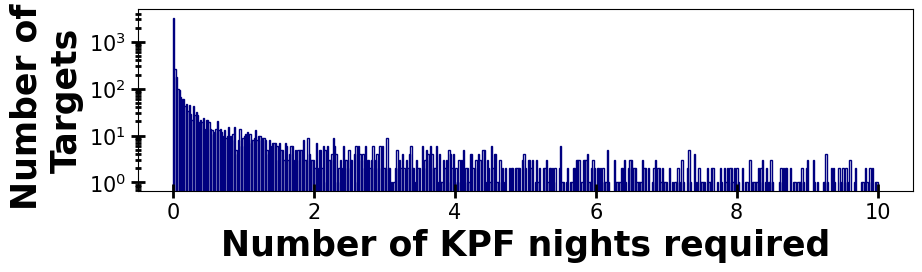

Number of targets before Keck time cut:  7358
Number of targets after Keck 5 night limit cut:  5843


In [ ]:
#Remove any remaining targets have expected RV semi-amplitudes below 1 m/s as stellar variability will likely 
#prevent measurements of their masses 

print('Number of targets before <1 m/s semi-amp cut: ',len(Full_TargetList))
#print('Number of known planet targets before <1 m/s semi-amp cut: ',len(Full_TargetList[Full_TargetList]))
Full_TargetList.drop(Full_TargetList[Full_TargetList['predicted_K_p'] < 1.0].index, inplace = True)
Full_TargetList.reset_index(drop=True,inplace=True)
print('Number of targets after <1 m/s semi-amp cut: ',len(Full_TargetList))

#Now calculate the RV precision that KPF could deliver in 30 minutes on each target
#and, based on that precision, how many observations are needed to achieve the requisite
#2- or 5-sigma mass precision based on Cloutier+ 2018
KPF_30min_Precision=np.empty_like(Full_TargetList['name'])
Nobs_RV_KPF=np.empty_like(Full_TargetList['name'])

for i in range(0,len(Full_TargetList)):
    if Full_TargetList['mass_sigma_needed'][i]>0:        
        sigma_rv_val, wvl_arr, snr_ord, dv_ord = kpf_photon_noise_estimate(Full_TargetList['teff_*'][i],Full_TargetList['vmag'][i],1800,quiet=True)
        KPF_30min_Precision[i] = sigma_rv_val
        Nobs_RV_KPF[i] = 3.0 * Full_TargetList['mass_sigma_needed'][i]**2 * sigma_rv_val**2 / (Full_TargetList['predicted_K_p'][i]**2)
    else:
        KPF_30min_Precision[i] = -1
        Nobs_RV_KPF[i] = 0

Full_TargetList['KPF_30min_RVSig'] = KPF_30min_Precision
Full_TargetList['Nobs_30m_KPF'] = Nobs_RV_KPF

#Plot distribution of Keck nights needed to confirm each planet/candidate
fig = plt.figure(1,[10,8])
n_bins=np.linspace(0,10,500)
ax1 = fig.add_subplot(311)
ax1.hist(Nobs_RV_KPF[Nobs_RV_KPF>0.]/48., n_bins, edgecolor='navy', linewidth=1, fill=False, histtype='bar', stacked=False,rwidth=.95)
ax1.tick_params(axis='both',which='major',labelsize=15,direction='inout',length=10,width=2)
ax1.tick_params(axis='both',which='minor',labelsize=15,direction='inout',length=5,width=2)
ax1.set_xlabel('Number of KPF nights required',fontsize=25,fontweight='bold')
ax1.set_ylabel('Number of \nTargets',fontsize=25,fontweight='bold')
ax1.set_yscale('log')
plt.show()

#And now remove any potential targets that would take more than 3 nights of Keck time to get a mass for (Nobs > 40)
print('Number of targets before Keck time cut: ',len(Full_TargetList))
Full_TargetList.drop(Full_TargetList[Full_TargetList['Nobs_30m_KPF'] > 60.0].index, inplace = True)
Full_TargetList.reset_index(drop=True,inplace=True)
print('Number of targets after Keck 3 night limit cut: ',len(Full_TargetList))

## Calculate Transmission & Emission Figures of Merit

In [8]:
#Define some constants for use in calculating Eclipse Depth
hband_wave = 1.65e-6  #center of the H band in meters
r_earth_m = 6.378e+6
r_sun_m = 6.957e+8

#Add a column for C/O ratio, assume it is solar
Full_TargetList['logCtoO']=[-0.26]*len(Full_TargetList)

#initialize columns for the mean molecular weight and the two figure of merit values
Full_TargetList['mmw'] = np.empty_like(Full_TargetList['radius_p'])
Full_TargetList['FoM_trans']=np.empty_like(Full_TargetList['radius_p'])
Full_TargetList['FoM_emiss']=np.empty_like(Full_TargetList['radius_p'])
Full_TargetList['eclipse_depth']=np.empty_like(Full_TargetList['radius_p'])

wave = 1.65e-6 # middle of H-band in m

print('Index, Teq, logMet, logCtoO, M_*, R_*, M_pl, R_pl, logg, mmw')
for i in range(0,len(Full_TargetList)):
    RpRs = (Full_TargetList['radius_p'][i]* 6.378e+6)/(Full_TargetList['radius_*'][i]* 6.957e+8)
    logMet_pl = massMetalRelation(Full_TargetList['met_*'][i], Full_TargetList['mass_p'][i])

    #Calculate the planet's mean molecular weight -- Need Tp, Rp, Rstar, logg planet, log metallicity & log C/O ratio
    Full_TargetList['mmw'][i] = calcMMW(Full_TargetList['teq_p'][i], logMet_pl, Full_TargetList['logCtoO'][i], 
                     Full_TargetList['radius_p'][i],Full_TargetList['radius_*'][i], Full_TargetList['logg_p'][i])[0]

    #print(i,Full_TargetList['teq_p'][i], np.round(logMet_pl,2), Full_TargetList['logCtoO'][i], 
    #      Full_TargetList['mass_*'][i], Full_TargetList['radius_*'][i],Full_TargetList['mass_p'][i],Full_TargetList['radius_p'][i], 
    #      np.round(logg_pl,2),mmw[i])

    #Calculate transmission spectroscopy figure of merit
    Full_TargetList['FoM_trans'][i] = calc_FoM(Full_TargetList['mass_p'][i], Full_TargetList['radius_p'][i], Full_TargetList['teq_p'][i], 
                            Full_TargetList['mmw'][i], Full_TargetList['radius_*'][i], Full_TargetList['hmag'][i])

    #Calculate the emission spectroscopy figure of merit
    # Note: Geoff multiplies his SNR Emission by 1E4 to make the numbers less tiny, as emission depths are 
    # typically small (>=10x smaller than transit depths)
    Full_TargetList['FoM_emiss'][i] = calc_FoMe(Full_TargetList['teq_p'][i],Full_TargetList['teff_*'][i],wave,RpRs,Full_TargetList['hmag'][i])*(1e4)

    Full_TargetList['eclipse_depth'][i]=eclipsedepth(Full_TargetList['teq_p'][i],Full_TargetList['teff_*'][i],hband_wave,(Full_TargetList['radius_p'][i]*r_earth_m)/(Full_TargetList['radius_*'][i]*r_sun_m))

Index, Teq, logMet, logCtoO, M_*, R_*, M_pl, R_pl, logg, mmw


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

In [24]:
Cycle8_Sectors = np.arange(11)+97
N_Sectors=np.arange(13)+14
Eq_Sectors=np.arange(5)+42

EM_Sectors = np.concatenate((Cycle8_Sectors,N_Sectors,Eq_Sectors),axis=0)
EM_Sectors 

#NS_Sectors=np.arange(26)+1
#Eq_Sectors=np.arange(5)+42
#EM_Sectors = np.append(NS_Sectors,Eq_Sectors)
#EM_Sectors

array([ 97,  98,  99, 100, 101, 102, 103, 104, 105, 106, 107,  14,  15,
        16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  42,  43,
        44,  45,  46])

## Add in information about current / future TESS observations

In [25]:
import random

#Read in info about TESS sectors
TESS_Sectors=pd.read_csv('TESS_Pointings/TESS_CommittedPointings_S1-96.csv')

################################
##   Future Transits in EM2   ##
################################
last_transit_date = [-1]*len(Full_TargetList['name'])  #initialize array to -1 to represent starting assumption that TESS hasn't looked at them
last_transit_sector = [-1]*len(Full_TargetList['name'])  #initialize array to -1 to represent starting assumption that TESS hasn't looked at them


for i in range(0,len(Full_TargetList)):
    outID, outEclipLong, outEclipLat, outSec, outCam, outCcd,outColPix, outRowPix, scinfo = tess_stars2px_function_entry(0, Full_TargetList['RA'][i], Full_TargetList['dec'][i])
    #print(Targets['name'][i]+' in Sectors: ',outSec)

    if np.min(outSec) != -1:
        period = Full_TargetList['period_p'][i]
        epoch = Full_TargetList['epoch_p'][i]

        StartDates = TESS_Sectors['JD_StartDate'][outSec-1].to_numpy()
        EndDates = TESS_Sectors['JD_EndDate'][outSec-1].to_numpy()

        for k in range(len(outSec)-1,-1,-1):           #iterate backwards through the list of sectors where star was observed
            time_diff = EndDates[k] - epoch
            n_orbits = np.floor(time_diff / period)
            sector_epoch = epoch + n_orbits*period     #start with epoch of last transit in the sector

            #Original Version
            #for ((sector_epoch >= StartDates[k]) and (sector_epoch <= EndDates[k])):
                #last_transit_date[i]=sector_epoch
                #break
            
            detected=0
            while ((sector_epoch >= StartDates[k]) and (sector_epoch <= EndDates[k]) and (detected==0)):
                if random.uniform(0, 1) <= fduty:
                    last_transit_date[i]=sector_epoch
                    last_transit_sector[i]=outSec[k]
                    #print('Last observed transit in Sector ',outSec[k])
                    detected=1
                else:
                    sector_epoch = sector_epoch-period

            if detected==1:
                break

Full_TargetList['LastScheduledTransitDate']=last_transit_date
Full_TargetList['LastScheduledTransitSector']=last_transit_sector


################################
##   Future Transits in EM3   ##
################################

TESS_Sectors=pd.read_csv('TESS_Pointings/TESS_FullPointings_S1-107.csv')
#applying Cycle 8 (S97-107) plans and then mapping back to S14 - 26 for N/S and S42-46 for the ecliptic

TESS_FutureSectors=pd.read_csv('TESS_Pointings/TESS_SimulatedEM3_S97-125.csv',dtype={'OrigSector':int,'EMSector':int,'StartDate':str,'JD_StartDate':np.float64,
    'EndDate':str,'JD_EndDate':np.float64,'SectorDuration':np.float64})

EM3_transit_date = [-1]*len(Full_TargetList['name'])  #initialize array to -1 to represent starting assumption that TESS hasn't looked at them
EM3_transit_sector = [-1]*len(Full_TargetList['name'])  #initialize array to -1 to represent starting assumption that TESS hasn't looked at them

Cycle8_Sectors = np.arange(11)+97
N_Sectors=np.arange(13)+14
Eq_Sectors=np.arange(5)+42
EM_Sectors = np.concatenate((Cycle8_Sectors,N_Sectors,Eq_Sectors),axis=0)

for i in range(0,len(Full_TargetList)):
    outID, outEclipLong, outEclipLat, outSec, outCam, outCcd,outColPix, outRowPix, scinfo = tess_stars2px_function_entry(0, Full_TargetList['RA'][i], Full_TargetList['dec'][i])
    #print('All Sectors:', outSec)

    outSec_EM = np.intersect1d(outSec, EM_Sectors)
    #print('EM3 Sectors:', outSec_EM)

    if np.min(outSec) != -1:
        period = Full_TargetList['period_p'][i]
        epoch = Full_TargetList['epoch_p'][i]

        StartDates=np.empty_like(outSec_EM)
        EndDates=np.empty_like(outSec_EM)
        
        for m in range(0,len(StartDates)):
            StartDates[m]=TESS_FutureSectors['JD_StartDate'][TESS_FutureSectors['OrigSector']==outSec_EM[m]]
            EndDates[m]=TESS_FutureSectors['JD_EndDate'][TESS_FutureSectors['OrigSector']==outSec_EM[m]]

        for k in range(len(outSec_EM)-1,-1,-1):     #iterate backwards through the list of sectors where star was observed
 
            time_diff = EndDates[k] - epoch
            n_orbits = np.floor(time_diff / period)
            sector_epoch = epoch + n_orbits*period


            #if ((sector_epoch >= StartDates[k]) and (sector_epoch <= EndDates[k])):
            #    #print('Transit happens in Sector ',outSec[k])
            #    EM3_transit_date[i]=sector_epoch
            #    break

            detected=0
            while ((sector_epoch >= StartDates[k]) and (sector_epoch <= EndDates[k]) and (detected==0)):
                if random.uniform(0, 1) <= fduty:
                    EM3_transit_date[i]=sector_epoch
                    EM3_transit_sector[i]=outSec_EM[k]
                    #print('Last observed transit in Sector ',outSec[k])
                    detected=1
                else:
                    sector_epoch = sector_epoch-period

            if detected==1:
                break            

Full_TargetList['LastEM3TransitDate']=EM3_transit_date
Full_TargetList['LastEM3TransitSector']=EM3_transit_sector


################################
##   Future Transits in EM4   ##
################################

#mapping back to S1-13 & S14 - 26 for N/S and S42-46 for the ecliptic

TESS_FutureSectors=pd.read_csv('TESS_Pointings/TESS_SimulatedEM4_S126-156.csv',dtype={'OrigSector':int,'EMSector':int,'StartDate':str,'JD_StartDate':np.float64,
    'EndDate':str,'JD_EndDate':np.float64,'SectorDuration':np.float64})

EM4_transit_date = [-1]*len(Full_TargetList['name'])  #initialize array to -1 to represent starting assumption that TESS hasn't looked at them
EM4_transit_sector = [-1]*len(Full_TargetList['name'])  #initialize array to -1 to represent starting assumption that TESS hasn't looked at them


#NS_Sectors=np.arange(26)+1
#Eq_Sectors=np.arange(5)+42
#EM_Sectors = np.append(NS_Sectors,Eq_Sectors)

EM_Sectors=np.arange(21)+1
#EM_Sectors = np.append(NS_Sectors


for i in range(0,len(Full_TargetList)):
    outID, outEclipLong, outEclipLat, outSec, outCam, outCcd,outColPix, outRowPix, scinfo = tess_stars2px_function_entry(0, Full_TargetList['RA'][i], Full_TargetList['dec'][i])
    #print('All Sectors:', outSec)

    outSec_EM = np.intersect1d(outSec, EM_Sectors)
    #print('EM4 Sectors:', outSec_EM)

    if np.min(outSec) != -1:
        period = Full_TargetList['period_p'][i]
        epoch = Full_TargetList['epoch_p'][i]

        StartDates=np.empty_like(outSec_EM)
        EndDates=np.empty_like(outSec_EM)
        
        for m in range(0,len(StartDates)):
            StartDates[m]=TESS_FutureSectors['JD_StartDate'][TESS_FutureSectors['OrigSector']==outSec_EM[m]]
            EndDates[m]=TESS_FutureSectors['JD_EndDate'][TESS_FutureSectors['OrigSector']==outSec_EM[m]]

        for k in range(len(outSec_EM)-1,-1,-1):     #iterate backwards through the list of sectors where star was observed
 
            time_diff = EndDates[k] - epoch
            n_orbits = np.floor(time_diff / period)
            sector_epoch = epoch + n_orbits*period
            #if ((sector_epoch >= StartDates[k]) and (sector_epoch <= EndDates[k])):
            #    #print('Transit happens in Sector ',outSec[k])
            #    EM4_transit_date[i]=sector_epoch
            #    break

            detected=0
            while ((sector_epoch >= StartDates[k]) and (sector_epoch <= EndDates[k]) and (detected==0)):
                if random.uniform(0, 1) <= fduty:
                    EM4_transit_date[i]=sector_epoch
                    EM4_transit_sector[i]=outSec_EM[k]
                    #print('Last observed transit in Sector ',outSec[k])
                    detected=1
                else:
                    sector_epoch = sector_epoch-period

            if detected==1:
                break     

Full_TargetList['LastEM4TransitDate']=EM4_transit_date
Full_TargetList['LastEM4TransitSector']=EM4_transit_sector

## Write Full Target List (all viable targets) to csv file

In [26]:
Full_TargetList.to_csv('RepPlanets_Target_List_Full_May2025_3NightCut.csv')
Full_TargetList.to_csv('../RepPlanets_Target_List_Full_May2025_3NightCut.csv')

# Generate Representative Target List from Known Planets Only

## Version that selects 750 transmission planets

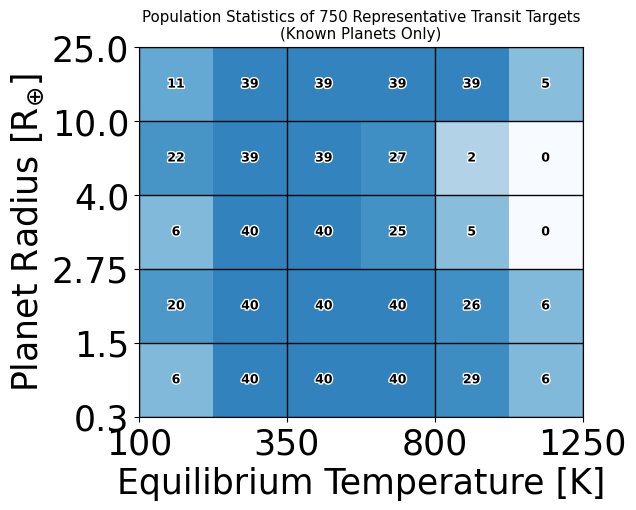

In [27]:
#Full_TargetList=pd.read_csv('RepPlanets_Target_List_Full_June2024_3NightCut.csv')
Full_TargetList=pd.read_csv('RepPlanets_Target_List_Full_May2025_3NightCut.csv')

cmap = plt.cm.Blues  # define the colormap
cmaplist = [cmap(i) for i in range(0,220)]
cmap = matplotlib.colors.LinearSegmentedColormap.from_list('Custom cmap', cmaplist, cmap.N)

nplanets=750

Rpvals = [0.3, 1.5, 2.75, 4.0, 10.0, 25.0]
Teqvals = [100, 350, 800, 1250, 1750, 2250, 3000]

Full_KPTargetList = Full_TargetList[Full_TargetList['disposition']=='KP']
Full_KPTargetList.reset_index(drop=True,inplace=True)

counter = np.zeros((len(Rpvals)-1, len(Teqvals)-1))
FoMs = np.zeros((len(Rpvals)-1, len(Teqvals)-1))
planets = []

iteration=0

while len(planets) < nplanets:
    for i in np.arange(len(Rpvals)-1):
        for j in np.arange(len(Teqvals)-1):
            # Index of all planets that fall within this bin
            idx = ((Rpvals[i] <= Full_KPTargetList['radius_p'].values)*(Full_KPTargetList['radius_p'].values < Rpvals[i+1])*(Teqvals[j] <= Full_KPTargetList['teq_p'].values) * (Full_KPTargetList['teq_p'].values < Teqvals[j + 1]))

            # If no planets in the box, then continue on to next box
            if sum(idx) == 0:
                continue

            # If running first time, grab largest FoM and stash into box
            if counter[i,j] == 0:
                # If only one planet in box, then straightforward
                if (len(idx) == 1):
                    maxFoM = Full_KPTargetList['FoM_trans'][idx]
                    planets.append(Full_KPTargetList['name'][idx])
                # If multiple, then grab the one with the highest FoM ranking
                else:
                    maxFoM = max(Full_KPTargetList['FoM_trans'][idx])
                    planets.append(Full_KPTargetList['name'][idx][Full_KPTargetList['FoM_trans'][idx] == max(Full_KPTargetList['FoM_trans'][idx])])
                FoMs[i,j] = maxFoM
                counter[i,j] = 1

            # Otherwise, grab the next largest FoM
            else:

                if np.sum(counter) == nplanets:
                    break

                nextoneidx, = np.where(Full_KPTargetList['FoM_trans'][idx] < FoMs[i,j])
                # If no more, then continue
                if len(nextoneidx)==0:
                    continue
                else:
                    # Grab the next largest one
                    maxFoM = max(np.array(Full_KPTargetList['FoM_trans'][idx])[nextoneidx])
                    FoMs[i, j] = maxFoM
                    planets.append(Full_KPTargetList['name'][idx][Full_KPTargetList['FoM_trans'][idx] == maxFoM])
                    counter[i, j] = counter[i,j] + 1

    iteration+=1


plt.imshow(counter,origin='lower',extent=(0,len(Teqvals)-1, 0, len(Rpvals)-1),cmap=cmap, vmin=0, vmax=170,norm='symlog')
plt.gca().axes.set_xticklabels(Teqvals)
plt.gca().axes.set_yticklabels(Rpvals)
plt.gca().grid(which='major', color='k', linestyle='-', linewidth=1)
plt.xlabel("Equilibrium Temperature [K]",fontsize=25)
plt.ylabel("Planet Radius [R$_{\oplus}$]",fontsize=25)
plt.title("Population Statistics of 750 Representative Transit Targets\n(Known Planets Only)")

for i in np.arange(len(Rpvals)-1):
    for j in np.arange(len(Teqvals)-1):
        txt = plt.text(np.mean([j,j+1]),np.mean([i,i+1]),int(counter[i][j]),ha='center',va='center',weight='bold')
        txt.set_path_effects([PathEffects.withStroke(linewidth=2, foreground='w')])

plt.show()
#plt.savefig('RepPlanets_KP_popstats_3NightCut.pdf',bbox_inches='tight')
#plt.close()

representative_planets_KP = planets[:]
representative_planets_KP = [i.values[0] for i in representative_planets_KP]

Targets_Rep750_KP = Full_KPTargetList.loc[Full_KPTargetList['name'].isin(representative_planets_KP)]
Targets_Rep750_KP.to_csv('../KnownPlanetsOnly_750Targets_May2025_3NightCut.csv')

## Eclipse Target list that selects exactly 150 Targets

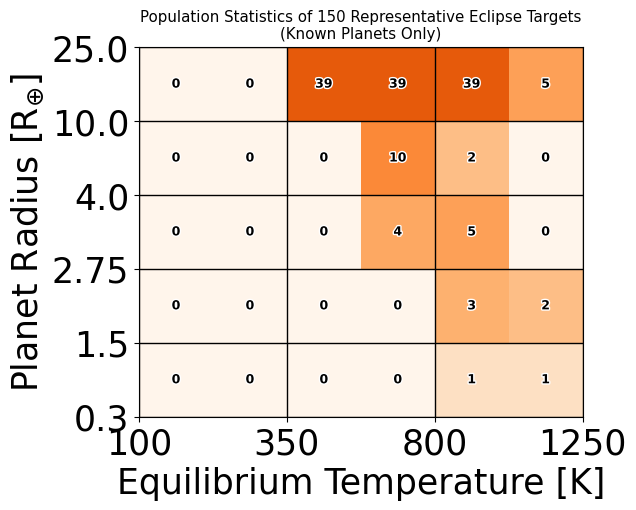

In [34]:
Full_TargetList=pd.read_csv('RepPlanets_Target_List_Full_May2025_3NightCut.csv')

cmap = plt.cm.Oranges  # define the colormap
cmaplist = [cmap(i) for i in range(0,220)]
cmap = matplotlib.colors.LinearSegmentedColormap.from_list('Custom cmap', cmaplist, cmap.N)

nplanets=150

Rpvals = [0.3, 1.5, 2.75, 4.0, 10.0, 25.0]
Teqvals = [100, 350, 800, 1250, 1750, 2250, 3000]

Full_KPTargetList = Full_TargetList[Full_TargetList['disposition']=='KP']
Full_KPTargetList.reset_index(drop=True,inplace=True)

Full_Eclipse_TargetList = Full_KPTargetList[Full_KPTargetList['eclipse_depth']>(20./1000000.)]
Full_Eclipse_TargetList.reset_index(drop=True,inplace=True)

## Updated check to make sure that getting the 10-sigma mass we want for eclipse targets 
## does not take more than 3 nights of KPF time

KPF_30min_Precision=np.empty_like(Full_Eclipse_TargetList['name'])
Nobs_RV_KPF=np.empty_like(Full_Eclipse_TargetList['name'])

for i in range(0,len(Full_Eclipse_TargetList)):
    if Full_TargetList['current_mass_sigma'][i]<10:        
        sigma_rv_val, wvl_arr, snr_ord, dv_ord = kpf_photon_noise_estimate(Full_Eclipse_TargetList['teff_*'][i],Full_Eclipse_TargetList['vmag'][i],1800,quiet=True)
        KPF_30min_Precision[i] = sigma_rv_val
        Nobs_RV_KPF[i] = 3.0 * 10.**2 * sigma_rv_val**2 / (Full_Eclipse_TargetList['predicted_K_p'][i]**2)
    else:
        KPF_30min_Precision[i] = -1
        Nobs_RV_KPF[i] = 0

Full_Eclipse_TargetList['KPF_30min_RVSig'] = KPF_30min_Precision
Full_Eclipse_TargetList['Nobs_30m_KPF'] = Nobs_RV_KPF

Full_Eclipse_TargetList.drop(Full_Eclipse_TargetList[Full_Eclipse_TargetList['Nobs_30m_KPF'] > 60.0].index, inplace = True)
Full_Eclipse_TargetList.reset_index(drop=True,inplace=True)

##########

counter = np.zeros((len(Rpvals)-1, len(Teqvals)-1))
FoMs = np.zeros((len(Rpvals)-1, len(Teqvals)-1))
planets = []

iteration=0

while len(planets) < nplanets:
    for i in np.arange(len(Rpvals)-1):
        for j in np.arange(len(Teqvals)-1):
            # Index of all planets that fall within this bin
            idx = ((Rpvals[i] <= Full_Eclipse_TargetList['radius_p'].values)*(Full_Eclipse_TargetList['radius_p'].values < Rpvals[i+1])*(Teqvals[j] <= Full_Eclipse_TargetList['teq_p'].values) * (Full_Eclipse_TargetList['teq_p'].values < Teqvals[j + 1]))

            # If no planets in the box, then continue on to next box
            if sum(idx) == 0:
                continue

            # If running first time, grab largest FoM and stash into box
            if counter[i,j] == 0:
                # If only one planet in box, then straightforward
                if (len(idx) == 1):
                    maxFoM = Full_Eclipse_TargetList['FoM_emiss'][idx]
                    planets.append(Full_Eclipse_TargetList['name'][idx])
                # If multiple, then grab the one with the highest FoM ranking
                else:
                    maxFoM = max(Full_Eclipse_TargetList['FoM_emiss'][idx])
                    planets.append(Full_Eclipse_TargetList['name'][idx][Full_Eclipse_TargetList['FoM_emiss'][idx] == max(Full_Eclipse_TargetList['FoM_emiss'][idx])])
                FoMs[i,j] = maxFoM
                counter[i,j] = 1

            # Otherwise, grab the next largest FoM
            else:

                if np.sum(counter) == nplanets:
                    break

                nextoneidx, = np.where(Full_Eclipse_TargetList['FoM_emiss'][idx] < FoMs[i,j])
                # If no more, then continue
                if len(nextoneidx)==0:
                    continue
                else:
                    # Grab the next largest one
                    maxFoM = max(np.array(Full_Eclipse_TargetList['FoM_emiss'][idx])[nextoneidx])
                    FoMs[i, j] = maxFoM
                    planets.append(Full_Eclipse_TargetList['name'][idx][Full_Eclipse_TargetList['FoM_emiss'][idx] == maxFoM])
                    counter[i, j] = counter[i,j] + 1

    iteration+=1


plt.imshow(counter,origin='lower',extent=(0,len(Teqvals)-1, 0, len(Rpvals)-1),cmap=cmap, vmin=0, vmax=170,norm='symlog')
plt.gca().axes.set_xticklabels(Teqvals)
plt.gca().axes.set_yticklabels(Rpvals)
plt.gca().grid(which='major', color='k', linestyle='-', linewidth=1)
plt.xlabel("Equilibrium Temperature [K]",fontsize=25)
plt.ylabel("Planet Radius [R$_{\oplus}$]",fontsize=25)
plt.title("Population Statistics of 150 Representative Eclipse Targets\n(Known Planets Only)")

for i in np.arange(len(Rpvals)-1):
    for j in np.arange(len(Teqvals)-1):
        txt = plt.text(np.mean([j,j+1]),np.mean([i,i+1]),int(counter[i][j]),ha='center',va='center',weight='bold')
        txt.set_path_effects([PathEffects.withStroke(linewidth=2, foreground='w')])

plt.show()
#plt.savefig('RepPlanets_KP_popstats_3NightCut.pdf',bbox_inches='tight')
#plt.close()

representative_emiss_planets_KP = planets[:]
representative_emiss_planets_KP = [i.values[0] for i in representative_emiss_planets_KP]

Targets_Rep150Emiss_KP = Full_Eclipse_TargetList.loc[Full_Eclipse_TargetList['name'].isin(representative_emiss_planets_KP)]
Targets_Rep150Emiss_KP.reset_index(drop=True,inplace=True)

#Update mass uncertainty requirement to 10 sigma for ecipse targets
for i in range(0,len(Targets_Rep150Emiss_KP)):
    if Targets_Rep150Emiss_KP['current_mass_sigma'][i]<10 or ~np.isfinite(Targets_Rep150Emiss_KP['current_mass_sigma'][i]):
        Targets_Rep150Emiss_KP['mass_sigma_needed'][i] = 10

Targets_Rep150Emiss_KP.to_csv('../KnownPlanetsOnly_150EmissionTargets_May2025_3NightCut.csv')

## Version that runs through exactly 25 iterations across the grid

In [29]:
Full_TargetList=pd.read_csv('RepPlanets_Target_List_Full_May2025_3NightCut.csv')

import matplotlib.patheffects as PathEffects
cmap = plt.cm.Blues  # define the colormap
# extract all colors from the .jet map
cmaplist = [cmap(i) for i in range(cmap.N)]
# create the new map
cmap = matplotlib.colors.LinearSegmentedColormap.from_list('Custom cmap', cmaplist, cmap.N)
bounds = np.linspace(0,200,9)
norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N)


Rpvals = [0.3, 1.5, 2.75, 4.0, 10.0, 25.0]
Teqvals = [100, 350, 800, 1250, 1750, 2250, 3000]

Viable_KP = Full_TargetList[Full_TargetList['disposition']=='KP']
Viable_KP.sort_values('FoM_trans',ascending=False,inplace=True)
Viable_KP.reset_index(drop=True,inplace=True)

counter = np.zeros((len(Rpvals)-1, len(Teqvals)-1))
FoMs = np.zeros((len(Rpvals)-1, len(Teqvals)-1))
planets = []

iteration=0

while iteration < 25:
    for i in np.arange(len(Rpvals)-1):
        for j in np.arange(len(Teqvals)-1):
            # Index of all planets that fall within this bin
            idx = ((Rpvals[i] <= Viable_KP['radius_p'].values)*(Viable_KP['radius_p'].values < Rpvals[i+1])*(Teqvals[j] <= Viable_KP['teq_p'].values) * (Viable_KP['teq_p'].values < Teqvals[j + 1]))

            # If no planets in the box, then continue on to next box
            if sum(idx) == 0:
                continue

            # If running first time, grab largest FoM and stash into box
            if counter[i,j] == 0:
                # If only one planet in box, then straightforward
                if (len(idx) == 1):
                    maxFoM = Viable_KP['FoM_trans'][idx]
                    planets.append(Viable_KP['name'][idx])
                # If multiple, then grab the one with the highest FoM ranking
                else:
                    maxFoM = max(Viable_KP['FoM_trans'][idx])
                    planets.append(Viable_KP['name'][idx][Viable_KP['FoM_trans'][idx] == max(Viable_KP['FoM_trans'][idx])])
                FoMs[i,j] = maxFoM
                counter[i,j] = 1

            # Otherwise, grab the next largest FoM
            else:

                if np.sum(counter) == 1000:
                    break

                nextoneidx, = np.where(Viable_KP['FoM_trans'][idx] < FoMs[i,j])
                # If no more, then continue
                if len(nextoneidx)==0:
                    continue
                else:
                    # Grab the next largest one
                    maxFoM = max(np.array(Viable_KP['FoM_trans'][idx])[nextoneidx])
                    FoMs[i, j] = maxFoM
                    planets.append(Viable_KP['name'][idx][Viable_KP['FoM_trans'][idx] == maxFoM])
                    counter[i, j] = counter[i,j] + 1

    iteration+=1


plt.imshow(counter,origin='lower',extent=(0,len(Teqvals)-1, 0, len(Rpvals)-1),cmap=cmap, norm=norm)
# plt.colorbar(label='Number of Targets', extend='max')
plt.gca().axes.set_xticklabels(Teqvals)
plt.gca().axes.set_yticklabels(Rpvals)
plt.gca().grid(which='major', color='k', linestyle='-', linewidth=1)
plt.xlabel("Equilibrium Temperature [K]",fontsize=25)
plt.ylabel("Planet Radius [R$_{\oplus}$]",fontsize=25)
plt.title("Population Statistics of 1000 Representative Transit Targets\n(Known Planets Only)")

for i in np.arange(len(Rpvals)-1):
    for j in np.arange(len(Teqvals)-1):
        txt = plt.text(np.mean([j,j+1]),np.mean([i,i+1]),int(counter[i][j]),ha='center',va='center',weight='bold')
        txt.set_path_effects([PathEffects.withStroke(linewidth=2, foreground='w')])

#plt.show()
plt.savefig('RepPlanets_KP_popstats_3NightCut.pdf',bbox_inches='tight')
plt.close()

representative_planets_KP = planets[:]
representative_planets_KP = [i.values[0] for i in representative_planets_KP]

Targets_Rep_KP = Viable_KP.loc[Viable_KP['name'].isin(representative_planets_KP)]
Targets_Rep_KP.sort_values(by=["FoM_trans"], ascending=False,inplace=True)
Targets_Rep_KP.to_csv('../RepPlanets_KnownPlanetsOnly_May2025_3NightCut.csv')

# Generate Representative Target List from Known Planets + TOIs

## Version that selects 750 planets

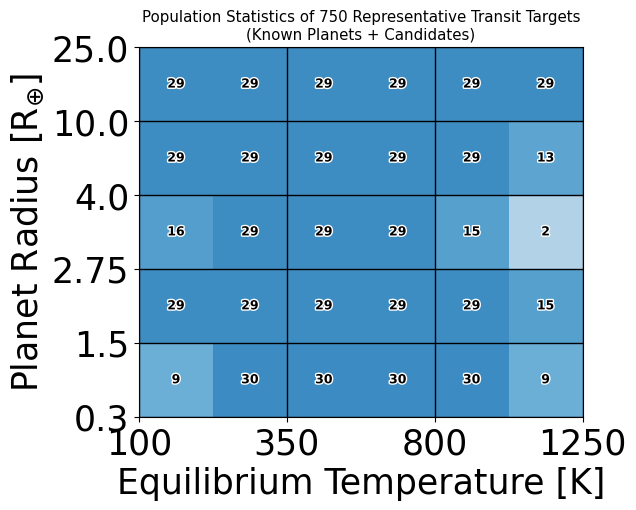

In [30]:
Full_TargetList=pd.read_csv('RepPlanets_Target_List_Full_May2025_3NightCut.csv')

cmap = plt.cm.Blues  # define the colormap
cmaplist = [cmap(i) for i in range(0,220)]
cmap = matplotlib.colors.LinearSegmentedColormap.from_list('Custom cmap', cmaplist, cmap.N)

nplanets=750

Rpvals = [0.3, 1.5, 2.75, 4.0, 10.0, 25.0]
Teqvals = [100, 350, 800, 1250, 1750, 2250, 3000]

counter = np.zeros((len(Rpvals)-1, len(Teqvals)-1))
FoMs = np.zeros((len(Rpvals)-1, len(Teqvals)-1))
planets = []

iteration=0

while len(planets) < nplanets:
    for i in np.arange(len(Rpvals)-1):
        for j in np.arange(len(Teqvals)-1):
            # Index of all planets that fall within this bin
            idx = ((Rpvals[i] <= Full_TargetList['radius_p'].values)*(Full_TargetList['radius_p'].values < Rpvals[i+1])*(Teqvals[j] <= Full_TargetList['teq_p'].values) * (Full_TargetList['teq_p'].values < Teqvals[j + 1]))

            # If no planets in the box, then continue on to next box
            if sum(idx) == 0:
                continue

            # If running first time, grab largest FoM and stash into box
            if counter[i,j] == 0:
                # If only one planet in box, then straightforward
                if (len(idx) == 1):
                    maxFoM = Full_TargetList['FoM_trans'][idx]
                    planets.append(Full_TargetList['name'][idx])
                # If multiple, then grab the one with the highest FoM ranking
                else:
                    maxFoM = max(Full_TargetList['FoM_trans'][idx])
                    planets.append(Full_TargetList['name'][idx][Full_TargetList['FoM_trans'][idx] == max(Full_TargetList['FoM_trans'][idx])])
                FoMs[i,j] = maxFoM
                counter[i,j] = 1

            # Otherwise, grab the next largest FoM
            else:

                if np.sum(counter) == nplanets:
                    break

                nextoneidx, = np.where(Full_TargetList['FoM_trans'][idx] < FoMs[i,j])
                # If no more, then continue
                if len(nextoneidx)==0:
                    continue
                else:
                    # Grab the next largest one
                    maxFoM = max(np.array(Full_TargetList['FoM_trans'][idx])[nextoneidx])
                    FoMs[i, j] = maxFoM
                    planets.append(Full_TargetList['name'][idx][Full_TargetList['FoM_trans'][idx] == maxFoM])
                    counter[i, j] = counter[i,j] + 1

    iteration+=1

plt.imshow(counter,origin='lower',extent=(0,len(Teqvals)-1, 0, len(Rpvals)-1),cmap=cmap, vmin=0, vmax=170,norm='symlog')
plt.gca().axes.set_xticklabels(Teqvals)
plt.gca().axes.set_yticklabels(Rpvals)
plt.gca().grid(which='major', color='k', linestyle='-', linewidth=1)
plt.xlabel("Equilibrium Temperature [K]",fontsize=25)
plt.ylabel("Planet Radius [R$_{\oplus}$]",fontsize=25)
plt.title("Population Statistics of 750 Representative Transit Targets\n(Known Planets + Candidates)")

for i in np.arange(len(Rpvals)-1):
    for j in np.arange(len(Teqvals)-1):
        txt = plt.text(np.mean([j,j+1]),np.mean([i,i+1]),int(counter[i][j]),ha='center',va='center',weight='bold')
        txt.set_path_effects([PathEffects.withStroke(linewidth=2, foreground='w')])

plt.show()
#plt.savefig('RepPlanets_750Planets_All_popstats_3NightCut.pdf',bbox_inches='tight')
#plt.close()

representative_planets_All = planets[:]
representative_planets_All = [i.values[0] for i in representative_planets_All]

Targets_Rep750_All = Full_TargetList.loc[Full_TargetList['name'].isin(representative_planets_All)]
Targets_Rep750_All.to_csv('../KnownPlanetsAndCandidates_750Targets_May2025_3NightCut.csv')

## Eclipse List of 150 planets from Known Planets + Candidates

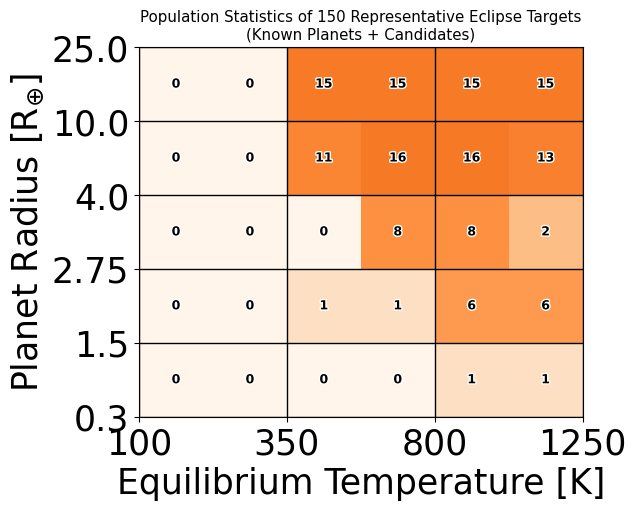

In [33]:
Full_TargetList=pd.read_csv('RepPlanets_Target_List_Full_May2025_3NightCut.csv')

cmap = plt.cm.Oranges  # define the colormap
cmaplist = [cmap(i) for i in range(0,220)]
cmap = matplotlib.colors.LinearSegmentedColormap.from_list('Custom cmap', cmaplist, cmap.N)

nplanets=150

Rpvals = [0.3, 1.5, 2.75, 4.0, 10.0, 25.0]
Teqvals = [100, 350, 800, 1250, 1750, 2250, 3000]

Full_Eclipse_TargetList = Full_TargetList[Full_TargetList['eclipse_depth']>(20./1000000.)]
Full_Eclipse_TargetList.reset_index(drop=True,inplace=True)

## Updated check to make sure that getting the 10-sigma mass we want for eclipse targets 
## does not take more than 3 nights of KPF time

KPF_30min_Precision=np.empty_like(Full_Eclipse_TargetList['name'])
Nobs_RV_KPF=np.empty_like(Full_Eclipse_TargetList['name'])

for i in range(0,len(Full_Eclipse_TargetList)):
    if Full_TargetList['current_mass_sigma'][i]<10:        
        sigma_rv_val, wvl_arr, snr_ord, dv_ord = kpf_photon_noise_estimate(Full_Eclipse_TargetList['teff_*'][i],Full_Eclipse_TargetList['vmag'][i],1800,quiet=True)
        KPF_30min_Precision[i] = sigma_rv_val
        Nobs_RV_KPF[i] = 3.0 * 10.**2 * sigma_rv_val**2 / (Full_Eclipse_TargetList['predicted_K_p'][i]**2)
    else:
        KPF_30min_Precision[i] = -1
        Nobs_RV_KPF[i] = 0

Full_Eclipse_TargetList['KPF_30min_RVSig'] = KPF_30min_Precision
Full_Eclipse_TargetList['Nobs_30m_KPF'] = Nobs_RV_KPF

Full_Eclipse_TargetList.drop(Full_Eclipse_TargetList[Full_Eclipse_TargetList['Nobs_30m_KPF'] > 60.0].index, inplace = True)
Full_Eclipse_TargetList.reset_index(drop=True,inplace=True)

##########


counter = np.zeros((len(Rpvals)-1, len(Teqvals)-1))
FoMs = np.zeros((len(Rpvals)-1, len(Teqvals)-1))
planets = []

iteration=0

while len(planets) < nplanets:
    for i in np.arange(len(Rpvals)-1):
        for j in np.arange(len(Teqvals)-1):
            # Index of all planets that fall within this bin
            idx = ((Rpvals[i] <= Full_Eclipse_TargetList['radius_p'].values)*(Full_Eclipse_TargetList['radius_p'].values < Rpvals[i+1])*(Teqvals[j] <= Full_Eclipse_TargetList['teq_p'].values) * (Full_Eclipse_TargetList['teq_p'].values < Teqvals[j + 1]))

            # If no planets in the box, then continue on to next box
            if sum(idx) == 0:
                continue

            # If running first time, grab largest FoM and stash into box
            if counter[i,j] == 0:
                # If only one planet in box, then straightforward
                if (len(idx) == 1):
                    maxFoM = Full_Eclipse_TargetList['FoM_emiss'][idx]
                    planets.append(Full_Eclipse_TargetList['name'][idx])
                # If multiple, then grab the one with the highest FoM ranking
                else:
                    maxFoM = max(Full_Eclipse_TargetList['FoM_emiss'][idx])
                    planets.append(Full_Eclipse_TargetList['name'][idx][Full_Eclipse_TargetList['FoM_emiss'][idx] == max(Full_Eclipse_TargetList['FoM_emiss'][idx])])
                FoMs[i,j] = maxFoM
                counter[i,j] = 1

            # Otherwise, grab the next largest FoM
            else:

                if np.sum(counter) == nplanets:
                    break

                nextoneidx, = np.where(Full_Eclipse_TargetList['FoM_emiss'][idx] < FoMs[i,j])
                # If no more, then continue
                if len(nextoneidx)==0:
                    continue
                else:
                    # Grab the next largest one
                    maxFoM = max(np.array(Full_Eclipse_TargetList['FoM_emiss'][idx])[nextoneidx])
                    FoMs[i, j] = maxFoM
                    planets.append(Full_Eclipse_TargetList['name'][idx][Full_Eclipse_TargetList['FoM_emiss'][idx] == maxFoM])
                    counter[i, j] = counter[i,j] + 1

    iteration+=1


plt.imshow(counter,origin='lower',extent=(0,len(Teqvals)-1, 0, len(Rpvals)-1),cmap=cmap, vmin=0, vmax=170,norm='symlog')
plt.gca().axes.set_xticklabels(Teqvals)
plt.gca().axes.set_yticklabels(Rpvals)
plt.gca().grid(which='major', color='k', linestyle='-', linewidth=1)
plt.xlabel("Equilibrium Temperature [K]",fontsize=25)
plt.ylabel("Planet Radius [R$_{\oplus}$]",fontsize=25)
plt.title("Population Statistics of 150 Representative Eclipse Targets\n(Known Planets + Candidates)")

for i in np.arange(len(Rpvals)-1):
    for j in np.arange(len(Teqvals)-1):
        txt = plt.text(np.mean([j,j+1]),np.mean([i,i+1]),int(counter[i][j]),ha='center',va='center',weight='bold')
        txt.set_path_effects([PathEffects.withStroke(linewidth=2, foreground='w')])

plt.show()
#plt.savefig('RepPlanets_KP_popstats_3NightCut.pdf',bbox_inches='tight')
#plt.close()

representative_emiss_planets = planets[:]
representative_emiss_planets = [i.values[0] for i in representative_emiss_planets]

Targets_Rep150Emiss = Full_Eclipse_TargetList.loc[Full_Eclipse_TargetList['name'].isin(representative_emiss_planets)]
Targets_Rep150Emiss.reset_index(drop=True,inplace=True)

#Update mass uncertainty requirement to 10 sigma for ecipse targets
for i in range(0,len(Targets_Rep150Emiss)):
    if Targets_Rep150Emiss['current_mass_sigma'][i]<10 or ~np.isfinite(Targets_Rep150Emiss['current_mass_sigma'][i]):
        Targets_Rep150Emiss['mass_sigma_needed'][i] = 10

Targets_Rep150Emiss.to_csv('../KnownPlanetsAndCandidates_150EmissionTargets_May2025_3NightCut.csv')

In [ ]:
print('done!')
datetime.datetime.now()

Rpvals = [0.3, 0.9, 1.5, 2.125, 2.75, 3.375, 4.0, 7, 10.0, 17.5, 25.0]
Teqvals = [100, 225, 350, 575, 800, 1025, 1250, 1500, 1750, 2000, 2250, 2625, 3000]

done!


datetime.datetime(2025, 5, 22, 12, 11, 29, 981545)

## Top FoM Transmission Grid with double the bins in each row/column

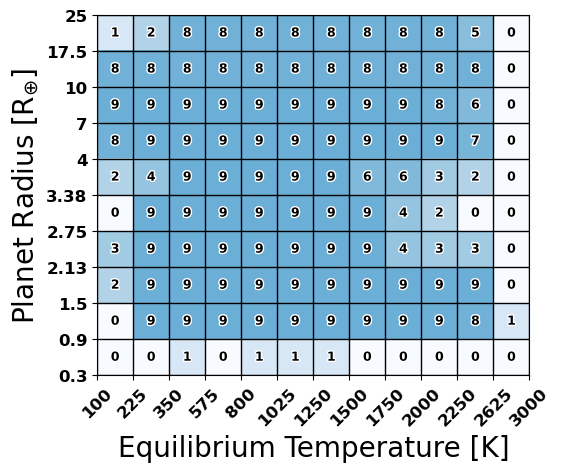

In [83]:
Full_TargetList=pd.read_csv('RepPlanets_Target_List_Full_May2025_3NightCut.csv')

cmap = plt.cm.Blues  # define the colormap
cmaplist = [cmap(i) for i in range(0,220)]
cmap = matplotlib.colors.LinearSegmentedColormap.from_list('Custom cmap', cmaplist, cmap.N)

nplanets=750

#Rpvals = [0.3, 1.5, 2.75, 4.0, 10.0, 25.0]
#Teqvals = [100, 350, 800, 1250, 1750, 2250, 3000]

Rpvals = [0.3, 0.9, 1.5, 2.125, 2.75, 3.375, 4.0, 7, 10.0, 17.5, 25.0]
Teqvals = [100, 225, 350, 575, 800, 1025, 1250, 1500, 1750, 2000, 2250, 2625, 3000]

counter = np.zeros((len(Rpvals)-1, len(Teqvals)-1))
FoMs = np.zeros((len(Rpvals)-1, len(Teqvals)-1))
planets = []

iteration=0

while len(planets) < nplanets:
    for i in np.arange(len(Rpvals)-1):
        for j in np.arange(len(Teqvals)-1):
            # Index of all planets that fall within this bin
            idx = ((Rpvals[i] <= Full_TargetList['radius_p'].values)*(Full_TargetList['radius_p'].values < Rpvals[i+1])*(Teqvals[j] <= Full_TargetList['teq_p'].values) * (Full_TargetList['teq_p'].values < Teqvals[j + 1]))

            # If no planets in the box, then continue on to next box
            if sum(idx) == 0:
                continue

            # If running first time, grab largest FoM and stash into box
            if counter[i,j] == 0:
                # If only one planet in box, then straightforward
                if (len(idx) == 1):
                    maxFoM = Full_TargetList['FoM_trans'][idx]
                    planets.append(Full_TargetList['name'][idx])
                # If multiple, then grab the one with the highest FoM ranking
                else:
                    maxFoM = max(Full_TargetList['FoM_trans'][idx])
                    planets.append(Full_TargetList['name'][idx][Full_TargetList['FoM_trans'][idx] == max(Full_TargetList['FoM_trans'][idx])])
                FoMs[i,j] = maxFoM
                counter[i,j] = 1

            # Otherwise, grab the next largest FoM
            else:

                if np.sum(counter) == nplanets:
                    break

                nextoneidx, = np.where(Full_TargetList['FoM_trans'][idx] < FoMs[i,j])
                # If no more, then continue
                if len(nextoneidx)==0:
                    continue
                else:
                    # Grab the next largest one
                    maxFoM = max(np.array(Full_TargetList['FoM_trans'][idx])[nextoneidx])
                    FoMs[i, j] = maxFoM
                    planets.append(Full_TargetList['name'][idx][Full_TargetList['FoM_trans'][idx] == maxFoM])
                    counter[i, j] = counter[i,j] + 1

    iteration+=1

import matplotlib.patheffects as PathEffects

plt.imshow(counter,origin='lower',extent=(0,len(Teqvals)-1, 0, len(Rpvals)-1),cmap=cmap, vmin=0, vmax=170,norm='symlog')

rp_labels = ['0.3', '0.9', '1.5', '2.13', '2.75', '3.38', '4', '7', '10', '17.5', '25']
plt.gca().axes.set_yticks(np.arange(len(Rpvals)),)
plt.gca().axes.set_yticklabels(rp_labels,fontsize=12,fontweight='bold')

teq_labels = ['100', '225', '350', '575', '800', '1025', '1250', '1500', '1750', '2000', '2250', '2625', '3000']
plt.gca().axes.set_xticks(np.arange(len(Teqvals)))
plt.gca().axes.set_xticklabels(teq_labels,fontsize=12,fontweight='bold',rotation=45)

plt.gca().grid(which='major', color='k', linestyle='-', linewidth=1)
plt.xlabel("Equilibrium Temperature [K]",fontsize=20)
plt.ylabel("Planet Radius [R$_{\oplus}$]",fontsize=20)
#plt.title("Population Statistics of All Viable Ariel Targets \n(Known Planets and Planet Candidates)")

for i in np.arange(len(Rpvals)-1):
    for j in np.arange(len(Teqvals)-1):
        txt = plt.text(np.mean([j,j+1]),np.mean([i,i+1]),int(counter[i][j]),ha='center',va='center',weight='bold')
        txt.set_path_effects([PathEffects.withStroke(linewidth=2, foreground='w')])

plt.tight_layout()
plt.show()
#plt.close()

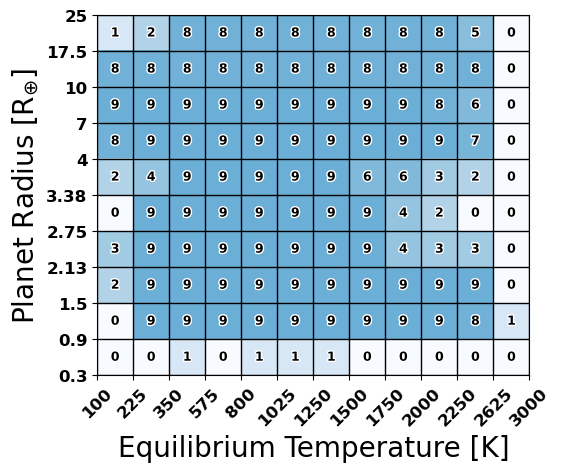

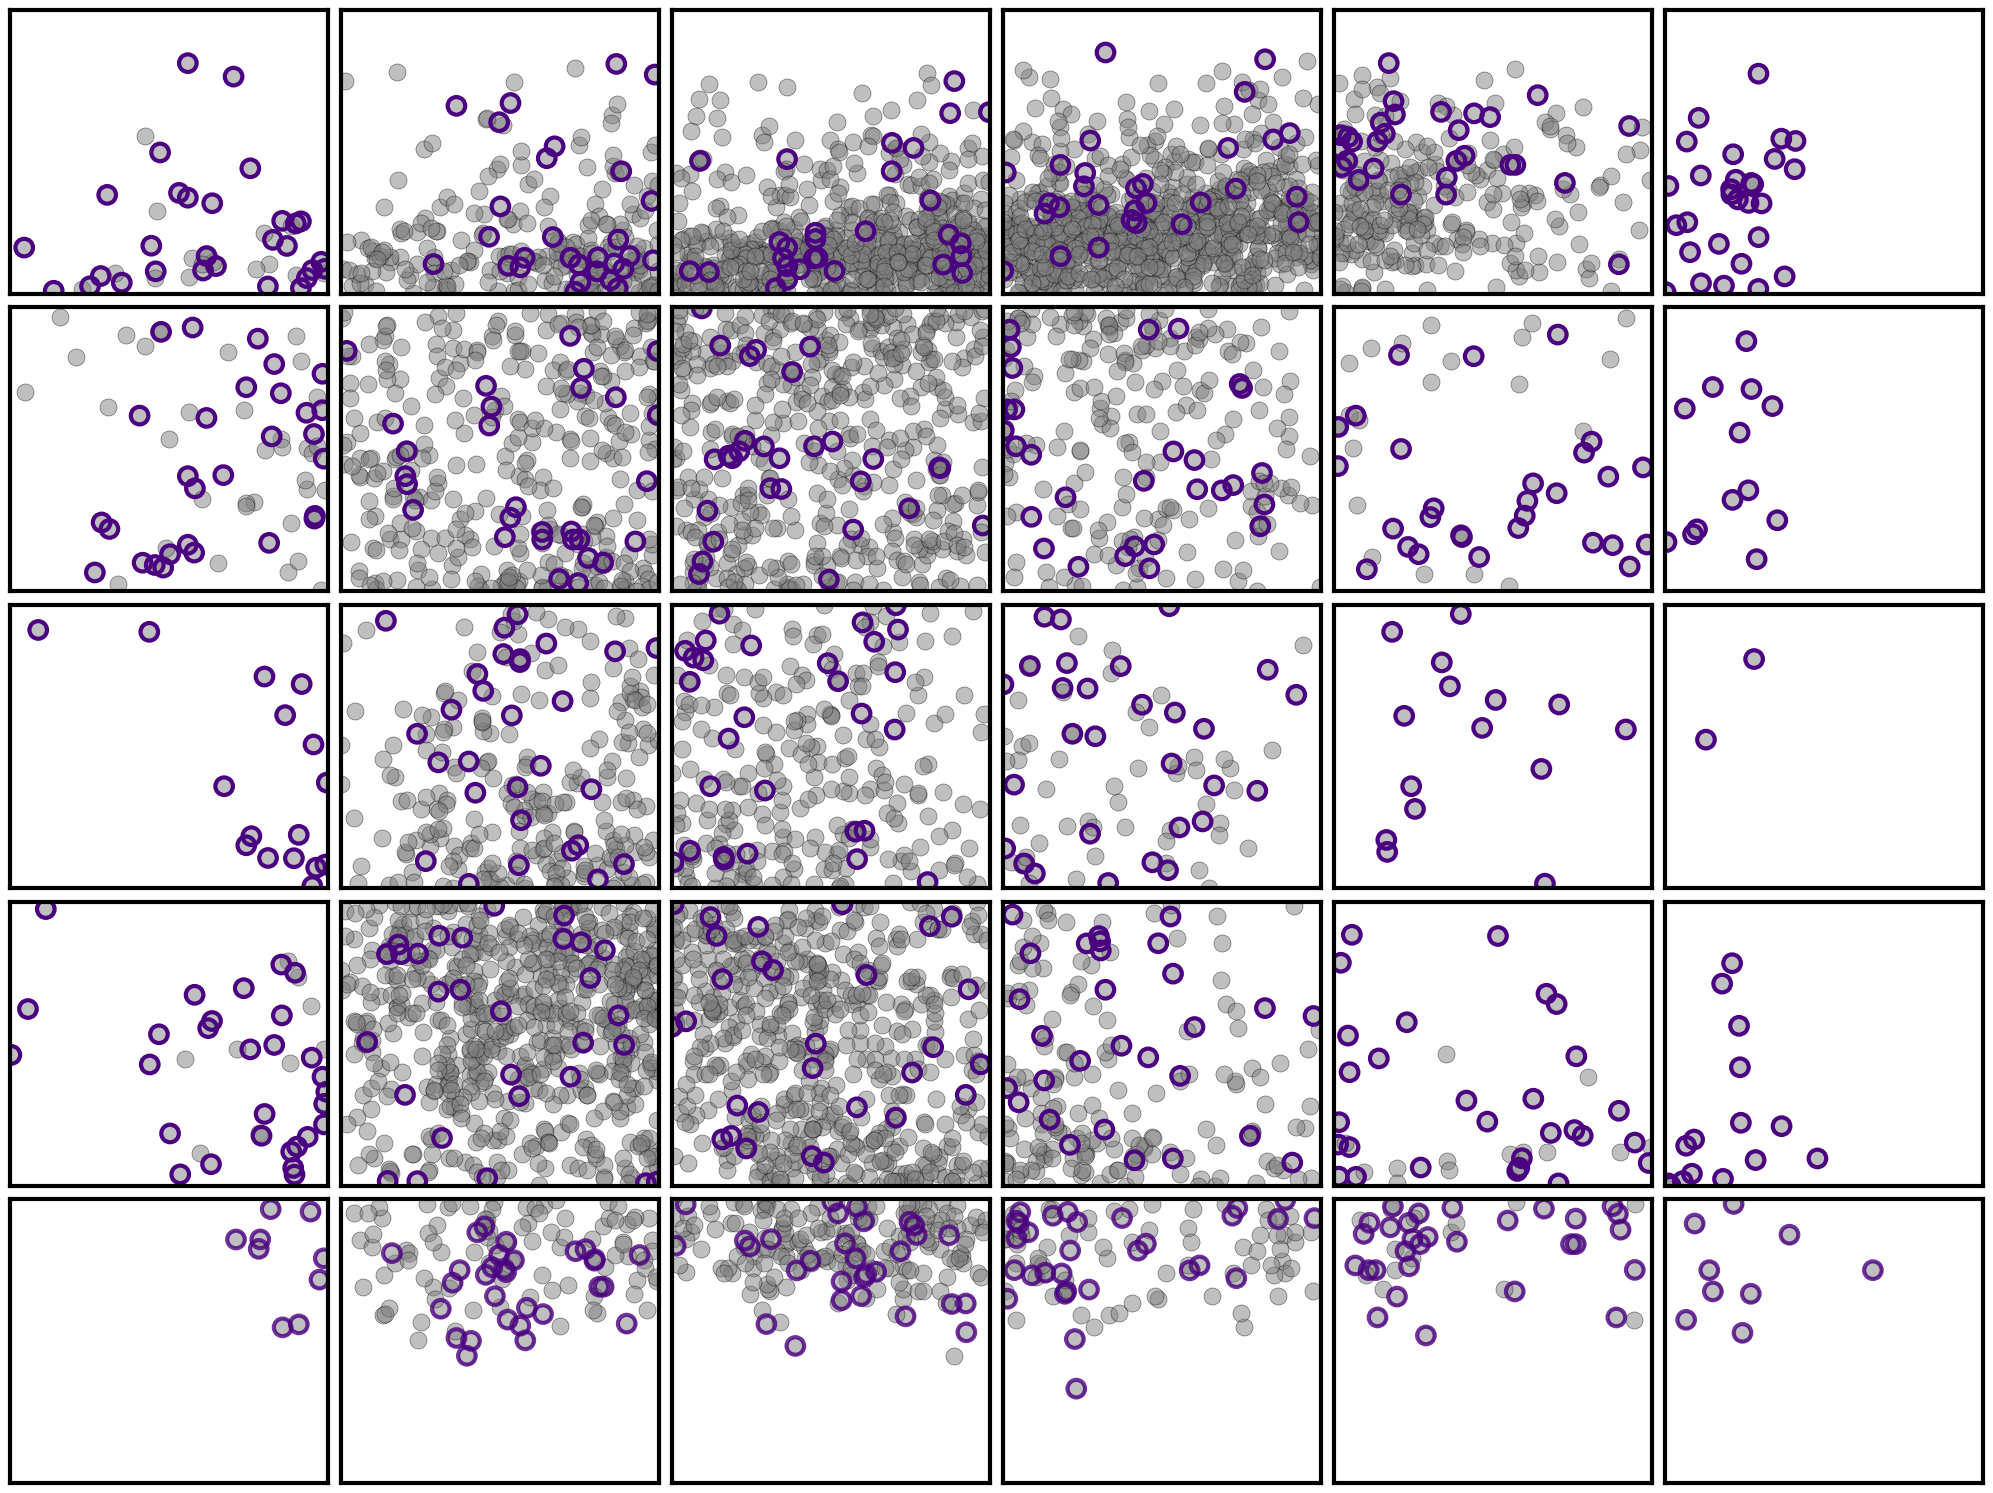

In [150]:
Full_TargetList=pd.read_csv('RepPlanets_Target_List_Full_May2025_3NightCut.csv')
Rep_TargetList=pd.read_csv('../KnownPlanetsAndCandidates_750Targets_May2025_3NightCut.csv')

Rpvals = [0.3, 1.5, 2.75, 4.0, 10.0, 25.0]
Teqvals = [100, 350, 800, 1250, 1750, 2250, 3000]

fig = plt.figure(1,[20,15])
fig.patch.set_facecolor('white')

circ_sz = 150
circ_col = 'grey' 

sq_sz = 160
sq_col = 'none'

iterator=1

for j in np.arange(len(Teqvals)-1):

    loc_full = ((10 <= Full_TargetList['radius_p'].values)*(Full_TargetList['radius_p'].values < 25)*(Teqvals[j] <= Full_TargetList['teq_p'].values) * (Full_TargetList['teq_p'].values < Teqvals[j + 1]))
    loc_sel = ((10 <= Rep_TargetList['radius_p'].values)*(Rep_TargetList['radius_p'].values < 25)*(Teqvals[j] <= Rep_TargetList['teq_p'].values) * (Rep_TargetList['teq_p'].values < Teqvals[j + 1]))

    ax_temp = fig.add_subplot(5,6,iterator)
    ax_temp.scatter(Full_TargetList['teq_p'][loc_full],Full_TargetList['radius_p'][loc_full],s=circ_sz,c=circ_col,edgecolor='black',linewidth=0.5,zorder=1,alpha=.5) 
    ax_temp.scatter(Rep_TargetList['teq_p'][loc_sel],Rep_TargetList['radius_p'][loc_sel],s=sq_sz,c=sq_col,edgecolor='indigo',linewidth=3,zorder=2) 
    ax_temp.set_xlim(Teqvals[j],Teqvals[j+1])
    ax_temp.set_ylim([10,25])
    
    if j == 9:
        ax_temp.set_yticks([10,25],labels=['10','25'],fontsize=18)
    else:
        ax_temp.set_yticks([])
    ax_temp.set_xticks([]) #([Teqvals[j],Teqvals[j+1]],labels=[str(Teqvals[j]),str(Teqvals[j+1])],fontsize=14)
    plt.setp(ax_temp.spines.values(), linewidth=3)    
    iterator = iterator+1 


for j in np.arange(len(Teqvals)-1):

    loc_full = ((4 <= Full_TargetList['radius_p'].values)*(Full_TargetList['radius_p'].values < 10)*(Teqvals[j] <= Full_TargetList['teq_p'].values) * (Full_TargetList['teq_p'].values < Teqvals[j + 1]))
    loc_sel = ((4 <= Rep_TargetList['radius_p'].values)*(Rep_TargetList['radius_p'].values < 10)*(Teqvals[j] <= Rep_TargetList['teq_p'].values) * (Rep_TargetList['teq_p'].values < Teqvals[j + 1]))

    ax_temp = fig.add_subplot(5,6,iterator)
    ax_temp.scatter(Full_TargetList['teq_p'][loc_full],Full_TargetList['radius_p'][loc_full],s=circ_sz,c=circ_col,edgecolor='black',linewidth=0.5,zorder=1,alpha=.5) 
    ax_temp.scatter(Rep_TargetList['teq_p'][loc_sel],Rep_TargetList['radius_p'][loc_sel],s=sq_sz,c=sq_col,edgecolor='indigo',linewidth=3,zorder=2) 
    ax_temp.set_xlim(Teqvals[j],Teqvals[j+1])
    ax_temp.set_ylim([4,10])
    if j==9:
        ax_temp.set_yticks([4,10],labels=['4','10'],fontsize=18)
    else:
        ax_temp.set_yticks([])
    ax_temp.set_xticks([]) #([Teqvals[j],Teqvals[j+1]],labels=[str(Teqvals[j]),str(Teqvals[j+1])],fontsize=14)
    plt.setp(ax_temp.spines.values(), linewidth=3)
    iterator = iterator+1 


for j in np.arange(len(Teqvals)-1):

    loc_full = ((2.75 <= Full_TargetList['radius_p'].values)*(Full_TargetList['radius_p'].values < 4)*(Teqvals[j] <= Full_TargetList['teq_p'].values) * (Full_TargetList['teq_p'].values < Teqvals[j + 1]))
    loc_sel = ((2.75 <= Rep_TargetList['radius_p'].values)*(Rep_TargetList['radius_p'].values < 4)*(Teqvals[j] <= Rep_TargetList['teq_p'].values) * (Rep_TargetList['teq_p'].values < Teqvals[j + 1]))

    ax_temp = fig.add_subplot(5,6,iterator)
    ax_temp.scatter(Full_TargetList['teq_p'][loc_full],Full_TargetList['radius_p'][loc_full],s=circ_sz,c=circ_col,edgecolor='black',linewidth=0.5,zorder=1,alpha=.5) 
    ax_temp.scatter(Rep_TargetList['teq_p'][loc_sel],Rep_TargetList['radius_p'][loc_sel],s=sq_sz,c=sq_col,edgecolor='indigo',linewidth=3,zorder=2) 
    ax_temp.set_xlim(Teqvals[j],Teqvals[j+1])
    ax_temp.set_ylim([2.75,4])
    if j==9:
        ax_temp.set_yticks([2.75,4],labels=['2.75','4'],fontsize=18)
    else:
        ax_temp.set_yticks([])
    ax_temp.set_xticks([]) #([Teqvals[j],Teqvals[j+1]],labels=[str(Teqvals[j]),str(Teqvals[j+1])],fontsize=14)
    plt.setp(ax_temp.spines.values(), linewidth=3)
    iterator = iterator+1 


for j in np.arange(len(Teqvals)-1):

    loc_full = ((1.5 <= Full_TargetList['radius_p'].values)*(Full_TargetList['radius_p'].values < 2.75)*(Teqvals[j] <= Full_TargetList['teq_p'].values) * (Full_TargetList['teq_p'].values < Teqvals[j + 1]))
    loc_sel = ((1.5 <= Rep_TargetList['radius_p'].values)*(Rep_TargetList['radius_p'].values < 2.75)*(Teqvals[j] <= Rep_TargetList['teq_p'].values) * (Rep_TargetList['teq_p'].values < Teqvals[j + 1]))

    ax_temp = fig.add_subplot(5,6,iterator)
    ax_temp.scatter(Full_TargetList['teq_p'][loc_full],Full_TargetList['radius_p'][loc_full],s=circ_sz,c=circ_col,edgecolor='black',linewidth=0.5,zorder=1,alpha=.5) 
    ax_temp.scatter(Rep_TargetList['teq_p'][loc_sel],Rep_TargetList['radius_p'][loc_sel],s=sq_sz,c=sq_col,edgecolor='indigo',linewidth=3,zorder=2) 
    ax_temp.set_xlim(Teqvals[j],Teqvals[j+1])
    ax_temp.set_ylim([1.5,2.75])
    if j==9:
        ax_temp.set_yticks([1.5,2.75],labels=['1.5','2.75'],fontsize=18)
    else:
        ax_temp.set_yticks([])
    ax_temp.set_xticks([]) #([Teqvals[j],Teqvals[j+1]],labels=[str(Teqvals[j]),str(Teqvals[j+1])],fontsize=14)
    plt.setp(ax_temp.spines.values(), linewidth=3)
    iterator = iterator+1 


for j in np.arange(len(Teqvals)-1):

    loc_full = ((0.3 <= Full_TargetList['radius_p'].values)*(Full_TargetList['radius_p'].values < 1.5)*(Teqvals[j] <= Full_TargetList['teq_p'].values) * (Full_TargetList['teq_p'].values < Teqvals[j + 1]))
    loc_sel = ((0.3 <= Rep_TargetList['radius_p'].values)*(Rep_TargetList['radius_p'].values < 1.5)*(Teqvals[j] <= Rep_TargetList['teq_p'].values) * (Rep_TargetList['teq_p'].values < Teqvals[j + 1]))

    ax_temp = fig.add_subplot(5,6,iterator)
    ax_temp.scatter(Full_TargetList['teq_p'][loc_full],Full_TargetList['radius_p'][loc_full],s=circ_sz,c=circ_col,edgecolor='black',linewidth=0.5,zorder=1,alpha=.5) 
    ax_temp.scatter(Rep_TargetList['teq_p'][loc_sel],Rep_TargetList['radius_p'][loc_sel],s=sq_sz,c=sq_col,edgecolor='indigo',linewidth=3,zorder=2,alpha=.8) 
    ax_temp.set_xlim(Teqvals[j],Teqvals[j+1])
    ax_temp.set_ylim([0.3,1.5])
    if j==9:
        ax_temp.set_yticks([0.3,1.5],labels=['0.3','1.5'],fontsize=18)
    else:
        ax_temp.set_yticks([])
    ax_temp.set_xticks([])
    #ax_temp.set_xticks([Teqvals[j],Teqvals[j+1]],labels=[str(Teqvals[j]),str(Teqvals[j+1])],fontsize=18)
    plt.setp(ax_temp.spines.values(), linewidth=3)
    iterator = iterator+1 

fig.subplots_adjust(wspace=0, hspace=0)

#ax1.tick_params(axis='both',which='major',labelsize=20,direction='inout',length=15,width=1)

plt.tight_layout()
plt.show()